In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import pickle

In [47]:
# open a file in "./logs/8experts_baseline_lambada_internal_routing.json" and read its content
with open("./logs/8experts_baseline_lambada_internal_routing.json", "r") as f:
    data = json.load(f)

# print(data)

In [48]:
# find out the structure of the data
for key in data.keys():
    print(f"{key}: {type(data[key])}")

config: <class 'str'>
strategy: <class 'str'>
num_experts: <class 'int'>
dataset: <class 'str'>
samples: <class 'list'>
summary: <class 'dict'>


In [49]:
for key in data['samples'][0].keys():
    print(f"{key}: {type(data['samples'][0][key])}")

sample_id: <class 'int'>
num_tokens: <class 'int'>
loss: <class 'float'>
layers: <class 'list'>


In [50]:
for key in data['samples'][0]['layers'][0].keys():
    print(f"{key}: {type(data['samples'][0]['layers'][0][key])}")

print((data['samples'][0]['layers'][0]['router_logits_sample'][0]))
print((data['samples'][0]['layers'][0]['expert_weights'][0]))

layer: <class 'int'>
router_logits_shape: <class 'list'>
selected_experts: <class 'list'>
expert_weights: <class 'list'>
router_logits_sample: <class 'list'>
[-0.11767578125, -0.4609375, -0.24609375, -1.1796875, 0.181640625, 0.045654296875, 0.034912109375, 0.042724609375, -0.81640625, -0.984375, -0.828125, 1.1484375, -0.1845703125, -2.625, -0.40234375, -0.416015625, 1.640625, 1.1484375, -0.8203125, 0.765625, -1.8359375, -0.68359375, 0.1259765625, -0.71484375, -2.171875, -0.1689453125, 2.921875, -0.61328125, 0.79296875, -1.203125, -0.84375, -0.93359375, -0.7109375, -0.48828125, 0.73046875, -0.7265625, -0.78125, -0.28125, -0.50390625, -0.80859375, -1.0234375, -1.46875, -0.4296875, 0.1953125, -0.6015625, -1.8671875, -0.96484375, -0.9296875, -0.41796875, -0.78125, -1.0, 1.3359375, -0.6875, -2.6875, -0.5703125, -1.4921875, -0.052734375, 1.328125, -0.1826171875, -0.30078125, -1.4375, 0.08642578125, -0.75, -1.2265625]
[0.2470703125, 0.06884765625, 0.05078125, 0.05029296875, 0.0419921875, 0.04

In [51]:
"""
The structure of the JSON file is as follows:
{
  "config": string,
  "strategy": string,
  "num_experts": int,
  "dataset": string,
  "samples": [
    {
      "sample_id": int,
      "num_tokens": int,
      "loss": float,
      "layers": [
        "layer": int,
        "router_logits_shape": [int, int],
        "selected_experts": list[list[int]],
        "expert_weights": list[list[float]],
        "router_logits_sample": list[list[float]]
      ]
    }
  ]
}
"""

# I want an aggregate list of expert weights per layer across all samples
num_layers = len(data['samples'][0]['layers'])
layers_expert_weights = [[] for _ in range(num_layers)]
layers_expert_choices = [[] for _ in range(num_layers)]
layers_router_logits = [[] for _ in range(num_layers)]
layers_router_logits_raw = [[] for _ in range(num_layers)]
for sample in data['samples']:
    for layer in sample['layers']:
        layer_idx = layer['layer']
        layers_expert_weights[layer_idx].extend(layer['expert_weights'])
        layers_expert_choices[layer_idx].extend(layer['selected_experts'])
        layer_router_logits = layer['router_logits_sample']
        softmax_router_logits = np.exp(layer_router_logits) / np.sum(np.exp(layer_router_logits), axis=1, keepdims=True)
        layers_router_logits[layer_idx].extend(softmax_router_logits)
        layers_router_logits_raw[layer_idx].extend(layer_router_logits)



In [52]:
# The shape of layers_router_logits is (16, 5000, 64), 16 is the number of layers, 5000 is the number of tokens across all samples, 64 is the number of experts
# I want an array of shape (16, 320000) where each row is the flattened router logits for that layer, so that I can do an histogram of the router softmax outputs per layer
overall_router_logits = np.array([np.array(arr).flatten() for arr in layers_router_logits])
raw_flat_router_logits = np.array([np.array(arr).flatten() for arr in layers_router_logits_raw])

# I also want an array of shape (16, 64, 5000) so I can plot the distribution of the softmax outputs per expert per layer
softmax_router_logits_per_expert = np.array([np.array(arr).T for arr in layers_router_logits])
raw_router_logits_per_expert = np.array([np.array(arr).T for arr in layers_router_logits_raw])

In [53]:
# Now, layers_expert_weights is a list of length num_layers, where each element is a list of expert weights for that layer across all samples
# Similarly, layers_expert_choices is a list of length num_layers, where each element is a list of selected experts for that layer across all samples
# Let's convert them to numpy arrays for easier manipulation
layers_expert_weights = np.array([np.array(weights) for weights in layers_expert_weights])

In [54]:
# Let's create another list which is the sum of expert weights per token per layer
layers_expert_weights_sum = [np.sum(weights, axis=1) for weights in layers_expert_weights]

In [55]:
# using layers_expert_weights_sum, plot the distribution of the sum of expert weights per token for each layer
for layer_idx, weights_sum in enumerate(layers_expert_weights_sum):
    path_to_dir = "./plots/layers_expert_weights_sum"
    path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_expert_weights_sum_distribution.png")
    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue
    plt.figure(figsize=(10, 6))
    # make sure the x axis is between 0 and 1
    sns.histplot(weights_sum, bins=50, kde=True)
    plt.xlim(0, 1)
    plt.title(f"Distribution of Sum of Expert Weights per Token - Layer {layer_idx}")
    plt.xlabel("Sum of Expert Weights")
    plt.ylabel("Frequency")
    plt.grid()

    # Save the plot as a png file in ./plots/layer_{layer_idx}_expert_weights_sum_distribution.png
    os.makedirs(path_to_dir, exist_ok=True)
    plt.savefig(f"./plots/layers_expert_weights_sum/layer_{layer_idx}_expert_weights_sum_distribution.png")
    
    plt.show()
    

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [56]:
# Now I want to count how much each expert was chosen per layer
layers_expert_choice_counts = np.array([])
for layer_choices in layers_expert_choices:
    # layer_choices is a list of lists, where each inner list is the selected experts for a token
    # flatten the list
    flat_choices = [expert for token_choices in layer_choices for expert in token_choices]
    # count the occurrences of each expert
    unique, counts = np.unique(flat_choices, return_counts=True)
    choice_count_dict = dict(zip(unique, counts))
    layers_expert_choice_counts = np.append(layers_expert_choice_counts, np.array([choice_count_dict]))
# Print the expert choice counts per layer
print(layers_expert_choice_counts)

[{np.int64(0): np.int64(422), np.int64(1): np.int64(903), np.int64(2): np.int64(267), np.int64(3): np.int64(912), np.int64(4): np.int64(908), np.int64(5): np.int64(508), np.int64(6): np.int64(4369), np.int64(7): np.int64(529), np.int64(8): np.int64(503), np.int64(9): np.int64(80), np.int64(10): np.int64(250), np.int64(11): np.int64(1260), np.int64(12): np.int64(312), np.int64(13): np.int64(464), np.int64(14): np.int64(350), np.int64(15): np.int64(192), np.int64(16): np.int64(833), np.int64(17): np.int64(778), np.int64(18): np.int64(500), np.int64(19): np.int64(541), np.int64(20): np.int64(552), np.int64(21): np.int64(898), np.int64(22): np.int64(544), np.int64(23): np.int64(258), np.int64(24): np.int64(216), np.int64(25): np.int64(340), np.int64(26): np.int64(545), np.int64(27): np.int64(391), np.int64(28): np.int64(639), np.int64(29): np.int64(383), np.int64(30): np.int64(343), np.int64(31): np.int64(417), np.int64(32): np.int64(563), np.int64(33): np.int64(778), np.int64(34): np.int6

In [57]:
# Plot the expert choice counts per layer as a bar plot
for layer_idx, choice_count_dict in enumerate(layers_expert_choice_counts):
    path_to_dir = "./plots/layer_expert_choice_counts"
    path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_expert_choice_counts.png")
    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue
    plt.figure(figsize=(20, 6))
    experts = list(choice_count_dict.keys())
    counts = list(choice_count_dict.values())
    sns.barplot(x=experts, y=counts)
    plt.title(f"Expert Choice Counts - Layer {layer_idx}")
    plt.xlabel("Expert")
    plt.ylabel("Count")

    # Save the plot as a png file in ./plots/layer_{layer_idx}_expert_choice_counts.png
    os.makedirs(path_to_dir, exist_ok=True)
    plt.savefig(path_to_save)
    
    plt.show()

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [58]:
path_to_dir = "./plots"
path_to_save = os.path.join(path_to_dir, f"combined_expert_weights_sum_distribution.png")
if os.path.exists(path_to_save):
    print(f"Combined plot already exists, skipping...")
else:
  # Now I want to combine layers_expert_weights_sum and plot an histogram of the sum of expert weights per token across all layers
  combined_weights_sum = np.concatenate(layers_expert_weights_sum)
  plt.figure(figsize=(10, 6))
  # make sure the x axis is between 0 and 1
  sns.histplot(combined_weights_sum, bins=50, kde=True)
  plt.xlim(0, 1)
  plt.title("Distribution of Sum of Expert Weights per Token - All Layers")
  plt.xlabel("Sum of Expert Weights")
  plt.ylabel("Frequency")
  plt.grid()
  # Save the plot as a png file in ./plots/combined_expert_weights_sum_distribution.png
  os.makedirs(path_to_dir, exist_ok=True)
  plt.savefig(path_to_save)

  plt.show()

Combined plot already exists, skipping...


In [59]:
# Plot an histogram of the overall_router_logits per layer
for layer_idx, router_logits in enumerate(overall_router_logits):
    path_to_dir = "./plots/layer_router_softmax"
    path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_router_softmax_distribution.png")
    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue
    plt.figure(figsize=(10, 6))
    sns.histplot(router_logits, bins=100, kde=True)
    plt.title(f"Distribution of Router Softmax Outputs per Layer - Layer {layer_idx}")
    plt.xlabel("Router Softmax Output")
    plt.ylabel("Frequency")
    # Save the plot as a png file in ./plots/layer_{layer_idx}_router_softmax_distribution.png
    os.makedirs(path_to_dir, exist_ok=True)
    plt.savefig(path_to_save)

    plt.show()

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [60]:
# plot an histogram of the softmax_router_logits_per_expert per layer per expert
num_experts = softmax_router_logits_per_expert.shape[1]
for layer_idx in range(softmax_router_logits_per_expert.shape[0]):
    for expert_idx in range(num_experts):
        path_to_dir = "./plots/layer_expert_router_softmax_distribution"
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_expert_{expert_idx}_router_softmax_distribution.png")
        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} expert {expert_idx} already exists, skipping...")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(softmax_router_logits_per_expert[layer_idx, expert_idx, :], bins=100, kde=True)
        plt.title(f"Distribution of Router Softmax Outputs - Layer {layer_idx} Expert {expert_idx}")
        plt.xlabel("Router Softmax Output")
        plt.ylabel("Frequency")
        # Save the plot as a png file in ./plots/layer_expert_router_softmax_distribution/layer_{layer_idx}_expert_{expert_idx}_router_softmax_distribution.png
        os.makedirs(path_to_dir, exist_ok=True)
        plt.savefig(path_to_save)
        

        plt.show()

Plot for layer 0 expert 0 already exists, skipping...
Plot for layer 0 expert 1 already exists, skipping...
Plot for layer 0 expert 2 already exists, skipping...
Plot for layer 0 expert 3 already exists, skipping...
Plot for layer 0 expert 4 already exists, skipping...
Plot for layer 0 expert 5 already exists, skipping...
Plot for layer 0 expert 6 already exists, skipping...
Plot for layer 0 expert 7 already exists, skipping...
Plot for layer 0 expert 8 already exists, skipping...
Plot for layer 0 expert 9 already exists, skipping...
Plot for layer 0 expert 10 already exists, skipping...
Plot for layer 0 expert 11 already exists, skipping...
Plot for layer 0 expert 12 already exists, skipping...
Plot for layer 0 expert 13 already exists, skipping...
Plot for layer 0 expert 14 already exists, skipping...
Plot for layer 0 expert 15 already exists, skipping...
Plot for layer 0 expert 16 already exists, skipping...
Plot for layer 0 expert 17 already exists, skipping...
Plot for layer 0 exp

In [61]:
num_experts = raw_router_logits_per_expert.shape[1]
            
# plot an histogram of the raw_router_logits_per_expert per layer per expert
for layer_idx in range(raw_router_logits_per_expert.shape[0]):
    for expert_idx in range(num_experts):
        path_to_dir = "./plots/layer_expert_raw_router_logits_distribution"
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_expert_{expert_idx}_raw_router_logits_distribution.png")
        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} expert {expert_idx} already exists, skipping...")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(raw_router_logits_per_expert[layer_idx, expert_idx, :], bins=100, kde=True)
        plt.title(f"Distribution of Raw Router Logits - Layer {layer_idx} Expert {expert_idx}")
        plt.xlabel("Raw Router Logit")
        plt.ylabel("Frequency")
        # Save the plot as a png file in ./plots/layer_expert_raw_router_logits_distribution/layer_{layer_idx}_expert_{expert_idx}_raw_router_logits_distribution.png
        os.makedirs(path_to_dir, exist_ok=True)
        plt.savefig(path_to_save)
        

        plt.show()

Plot for layer 0 expert 0 already exists, skipping...
Plot for layer 0 expert 1 already exists, skipping...
Plot for layer 0 expert 2 already exists, skipping...
Plot for layer 0 expert 3 already exists, skipping...
Plot for layer 0 expert 4 already exists, skipping...
Plot for layer 0 expert 5 already exists, skipping...
Plot for layer 0 expert 6 already exists, skipping...
Plot for layer 0 expert 7 already exists, skipping...
Plot for layer 0 expert 8 already exists, skipping...
Plot for layer 0 expert 9 already exists, skipping...
Plot for layer 0 expert 10 already exists, skipping...
Plot for layer 0 expert 11 already exists, skipping...
Plot for layer 0 expert 12 already exists, skipping...
Plot for layer 0 expert 13 already exists, skipping...
Plot for layer 0 expert 14 already exists, skipping...
Plot for layer 0 expert 15 already exists, skipping...
Plot for layer 0 expert 16 already exists, skipping...
Plot for layer 0 expert 17 already exists, skipping...
Plot for layer 0 exp

In [62]:
# Turn layers_router_logits_raw into a numpy array
layers_router_logits_raw = np.array([np.array(arr) for arr in layers_router_logits_raw])

def trim_top_and_bottom_experts(arr, trim_amount=2):
    if trim_amount == 0:
        return arr, None
    sorted_indices = np.argsort(arr, axis=-1)
    bottom_indices = sorted_indices[:, :, :trim_amount]
    top_indices = sorted_indices[:, :, -trim_amount:]
    trimmed_indices = np.concatenate([bottom_indices, top_indices], axis=-1)
    kept_indices = sorted_indices[:, :, trim_amount:-trim_amount]
    trimmed_arr = np.take_along_axis(arr, kept_indices, axis=-1)
    return np.array(trimmed_arr), np.array(trimmed_indices)


In [63]:
def plot_trimmed_expert_logits_distribution(arr, trim_amount=2, save_plots=True, test=False):
    trimmed_arr, _ = trim_top_and_bottom_experts(arr, trim_amount)
    # flatten the last dimension (from (num_layers, num_tokens, num_experts) to (num_layers, num_experts * num_tokens))
    trimmed_arr = np.array(trimmed_arr)
    flattened_arr = trimmed_arr.reshape(trimmed_arr.shape[0], -1)
    if test:
        print(f"trimmed_arr shape: {trimmed_arr.shape}")
        print(f"flattened_arr shape: {flattened_arr.shape}")
    path_to_dir = "./plots/trimmed_layer_router_logits"
    for layer_idx in range(trimmed_arr.shape[0]):
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_trimmed_{trim_amount * 2}_experts_router_logits_distribution.png")
        if save_plots and os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} already exists, skipping...")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(flattened_arr[layer_idx], bins=100, kde=True)
        plt.title(f"Distribution of Trimmed Raw Router Logits - Layer {layer_idx} (trimmed top {trim_amount} and bottom {trim_amount} experts)")
        plt.xlabel("Trimmed Raw Router Logit")
        plt.ylabel("Frequency")
        if save_plots:
            os.makedirs(path_to_dir, exist_ok=True)
            plt.savefig(path_to_save)
            
        plt.show()
        if test:
            return

In [64]:
amount_to_trim = [1, 2, 4]
for amt in amount_to_trim:
    plot_trimmed_expert_logits_distribution(layers_router_logits_raw, trim_amount=amt, test=False)

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...
Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot

In [65]:
with open("./logs/8experts_baseline_wikitext_internal_routing.json", "r") as f:
    data_wikitext = json.load(f)

In [66]:
# num_layers = len(data['samples'][0]['layers'])
# layers_expert_weights = [[] for _ in range(num_layers)]
# layers_expert_choices = [[] for _ in range(num_layers)]
# layers_router_logits = [[] for _ in range(num_layers)]
# layers_router_logits_raw = [[] for _ in range(num_layers)]
# for sample in data['samples']:
#     for layer in sample['layers']:
#         layer_idx = layer['layer']
#         layers_expert_weights[layer_idx].extend(layer['expert_weights'])
#         layers_expert_choices[layer_idx].extend(layer['selected_experts'])
#         layer_router_logits = layer['router_logits_sample']
#         softmax_router_logits = np.exp(layer_router_logits) / np.sum(np.exp(layer_router_logits), axis=1, keepdims=True)
#         layers_router_logits[layer_idx].extend(softmax_router_logits)
#         layers_router_logits_raw[layer_idx].extend(layer_router_logits)

num_layers_wikitext = len(data_wikitext['samples'][0]['layers'])
layers_router_logits_raw_wikitext = [[] for _ in range(num_layers_wikitext)]
for sample in data_wikitext['samples']:
    for layer in sample['layers']:
        layer_idx = layer['layer']
        layer_router_logits = layer['router_logits_sample']
        layers_router_logits_raw_wikitext[layer_idx].extend(layer_router_logits)

layers_router_logits_raw_wikitext = np.array(layers_router_logits_raw_wikitext)
print(f"layers_router_logits_raw_wikitext shape: {layers_router_logits_raw_wikitext.shape}")

layers_router_logits_raw_wikitext shape: (16, 4758, 64)


In [67]:
def plot_trimmed_expert_logits_multiple_distribution(arr1, arr2, trim_amount=2, save_plots=True, test=False, show=True):
    path_to_dir = "./plots/trimmed_layer_router_logits_comparison"
    trimmed_arr1, _ = trim_top_and_bottom_experts(arr1, trim_amount)
    trimmed_arr2, _ = trim_top_and_bottom_experts(arr2, trim_amount)
    # flatten the last dimension (from (num_layers, num_tokens, num_experts) to (num_layers, num_experts * num_tokens))
    flattened_arr1 = trimmed_arr1.reshape(trimmed_arr1.shape[0], -1)
    flattened_arr2 = trimmed_arr2.reshape(trimmed_arr2.shape[0], -1)
    if test:
      print(f"trimmed_arr1 shape: {trimmed_arr1.shape}")
      print(f"flattened_arr1 shape: {flattened_arr1.shape}")
      print(f"trimmed_arr2 shape: {trimmed_arr2.shape}")
      print(f"flattened_arr2 shape: {flattened_arr2.shape}")
    for layer_idx in range(trimmed_arr1.shape[0]):
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_trimmed_{trim_amount * 2}_experts_router_logits_distribution_comparison.png")
        if save_plots and os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} already exists, skipping...")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(flattened_arr1[layer_idx], bins=100, kde=True, color='blue', label='Lambada')
        sns.histplot(flattened_arr2[layer_idx], bins=100, kde=True, color='orange', label='Wikitext')
        plt.title(f"Distribution of Trimmed Raw Router Logits - Layer {layer_idx} (trimmed top {trim_amount} and bottom {trim_amount} experts)")
        plt.xlabel("Trimmed Raw Router Logit")
        plt.ylabel("Frequency")
        plt.legend()
        if save_plots:
            os.makedirs(path_to_dir, exist_ok=True)
            plt.savefig(path_to_save)
        
        if show:
            plt.show()
        else: 
            plt.close()
        if test:
            return

In [68]:
amount_to_trim = [1, 2, 4]
for amt in amount_to_trim:
  plot_trimmed_expert_logits_multiple_distribution(layers_router_logits_raw, layers_router_logits_raw_wikitext, trim_amount=amt, test=False, show=False)

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...
Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot

In [69]:
import textwrap
def plot_trimmed_expert_logits_multiple_distribution_different_trim_amount(arr1, arr2, trim_amount=[0, 1, 2, 4], save_plots=True, test=False, show=True):
    path_to_dir = "./plots/trimmed_layer_router_logits_comparison_multiple"
    # Plot multiple distributions with different trim amounts, 2 columns and len(trim_amount)/2 rows
    for layer_idx in range(arr1.shape[0]):
        plt.figure(figsize=(15, 5 * (len(trim_amount) // 2)))
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_trimmed_multiple_experts_router_logits_distribution_comparison.png")
        if save_plots and os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} already exists, skipping...")
            continue
        for i, amt in enumerate(trim_amount):
            trimmed_arr1, _ = trim_top_and_bottom_experts(arr1, amt)
            trimmed_arr2, _ = trim_top_and_bottom_experts(arr2, amt)
            # flatten the last dimension (from (num_layers, num_tokens, num_experts) to (num_layers, num_experts * num_tokens))
            flattened_arr1 = trimmed_arr1.reshape(trimmed_arr1.shape[0], -1)
            flattened_arr2 = trimmed_arr2.reshape(trimmed_arr2.shape[0], -1)
            if test:
                print(f"trimmed_arr1 shape: {trimmed_arr1.shape}")
                print(f"flattened_arr1 shape: {flattened_arr1.shape}")
                print(f"trimmed_arr2 shape: {trimmed_arr2.shape}")
                print(f"flattened_arr2 shape: {flattened_arr2.shape}")
            plt.subplot(len(trim_amount) // 2, 2, i + 1)
            sns.histplot(flattened_arr1[layer_idx], bins=100, kde=True, color='blue', label='Lambada')
            sns.histplot(flattened_arr2[layer_idx], bins=100, kde=True, color='orange', label='Wikitext')
            title_text = f"Distribution of Trimmed Raw Router Logits - Layer {layer_idx} (trimmed top {amt} and bottom {amt} experts out of {arr1.shape[2]}, lambda has {flattened_arr1.shape[1]} samples vs. wikitext has {flattened_arr2.shape[1]} samples )"
            plt.title("\n".join(textwrap.wrap(title_text, width=70)))
            # plt.title(f"Distribution of Trimmed Raw Router Logits - Layer {layer_idx} (trimmed top {amt} and bottom {amt} experts out of {arr1.shape[2]})")
            plt.xlabel("Trimmed Raw Router Logit")
            plt.ylabel("Frequency")
            plt.legend()
        
        plt.subplots_adjust(hspace=0.5)
        plt.tight_layout()
        if save_plots:
            os.makedirs(path_to_dir, exist_ok=True)
            plt.savefig(path_to_save)
        if show:
            plt.show()
        else: 
            plt.close()
        if test:
            return


    

In [70]:
plot_trimmed_expert_logits_multiple_distribution_different_trim_amount(layers_router_logits_raw, layers_router_logits_raw_wikitext, trim_amount=[0, 1, 2, 4], test=False, show=True)

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [71]:
def plot_trimmed_expert_logits_multiple_distribution_right_tail(arr1, arr2, tail_threshold=[0, 0.5, 1], save_plots=True, test=False, show=True):
    path_to_dir = "./plots/right_tail_layer_router_logits_comparison_multiple"
    rows = int(np.ceil(len(tail_threshold) / 2))
    # Plot multiple distributions with different tail thresholds, 2 columns and len(tail_threshold)/2 rows
    for layer_idx in range(arr1.shape[0]):
        path_to_save = os.path.join(path_to_dir, f"layer_{layer_idx}_right_tail_multiple_experts_router_logits_distribution_comparison.png")
        if save_plots and os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} already exists, skipping...")
            continue
        plt.figure(figsize=(15, 5 * rows))
        for i, threshold in enumerate(tail_threshold):
            layer_arr1 = arr1[layer_idx].copy()
            layer_arr2 = arr2[layer_idx].copy()
            # trim the experts whose logits are below the threshold actual value
            trimmed_arr1 = np.where(layer_arr1 >= threshold, layer_arr1, np.nan)
            trimmed_arr2 = np.where(layer_arr2 >= threshold, layer_arr2, np.nan)
            # count non-nan values per 
            arr1_non_nan = np.count_nonzero(~np.isnan(trimmed_arr1))
            arr2_non_nan = np.count_nonzero(~np.isnan(trimmed_arr2))
            # flatten the last dimension (from (num_tokens, num_experts) to (num_experts * num_tokens))
            flattened_arr1 = trimmed_arr1.reshape(-1)
            flattened_arr2 = trimmed_arr2.reshape(-1)
            if test:
                print(f"trimmed_arr1 shape: {trimmed_arr1.shape}")
                print(f"flattened_arr1 shape: {flattened_arr1.shape}")
                print(f"trimmed_arr2 shape: {trimmed_arr2.shape}")
                print(f"flattened_arr2 shape: {flattened_arr2.shape}")
            plt.subplot(rows, 2, i + 1)
            sns.histplot(flattened_arr1, bins=100, kde=True, color='blue', label='Lambada')
            sns.histplot(flattened_arr2, bins=100, kde=True, color='orange', label='Wikitext')
            title_text = f"Distribution of Right-Tail Raw Router Logits - Layer {layer_idx} (threshold: {threshold}, lambda has {arr1_non_nan} samples vs. wikitext has {arr2_non_nan} samples)"
            plt.title("\n".join(textwrap.wrap(title_text, width=70)))
            plt.xlabel("Right-Tail Raw Router Logit")
            plt.ylabel("Frequency")
            plt.legend()
        plt.tight_layout()
        if save_plots:
            os.makedirs(path_to_dir, exist_ok=True)
            plt.savefig(path_to_save)
        if show:
            plt.show()
        else:
            plt.close()
        if test:
            return

In [72]:
plot_trimmed_expert_logits_multiple_distribution_right_tail(layers_router_logits_raw, layers_router_logits_raw_wikitext, tail_threshold=[0, 0.5, 1], test=False, show=True)

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [73]:
trim_amt = [0, 1, 2, 4]
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    os.makedirs(path_to_dir, exist_ok=True)
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        

        kde = gaussian_kde(train_data.T)

        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)

        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)

    test_layer_data = layers_router_logits_raw_wikitext[layer_idx].flatten()
    probabilities = np.interp(test_layer_data, x_grid, cdf_grid)
    path_to_plot_dir = "./kde_models/plots"
    os.makedirs(path_to_plot_dir, exist_ok=True)
    path_to_save = os.path.join(path_to_plot_dir, f"kde_cumulative_density_layer_{layer_idx}_wikitext.png")
    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue
    # plot a histogram of the cumulative density between 0 and 1
    plt.figure(figsize=(10, 6))
    sns.histplot(probabilities, bins=100)
    plt.title(f"KDE Estimated Cumulative Density (scipy gaussian_kde) - Layer {layer_idx} on Wikitext Data")
    plt.xlabel("Estimated Cumulative Density")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
    plt.grid()
    plt.savefig(path_to_save)
    plt.show()


    

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [74]:
trim_amt = [0, 1, 2, 4]
# For each layer, for each trim amount, fit a KDE model on the trimmed data, then evaluate on the wikitext data and plot all trim amounts in a single figure with subplots
# We also plot another plot, which is the p-value histogram of the wikitext data under the trimmed KDE model. If the first plot is P(X <= x)
# then the p-value plot is P(X > x) = 1 - P(X <= x)
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_plot_dir = "./kde_models/plots"
    os.makedirs(path_to_plot_dir, exist_ok=True)
    path_to_save = os.path.join(path_to_plot_dir, f"kde_cumulative_density_layer_{layer_idx}_wikitext_multiple_trimmed.png")
    path_to_save_pvalue = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_multiple_trimmed.png")
    if os.path.exists(path_to_save) and os.path.exists(path_to_save_pvalue):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue
    path_to_dir = "./kde_models/models"
    os.makedirs(path_to_dir, exist_ok=True)
    test_points_probabilities = [None] * len(trim_amt)
    for idx, amt in enumerate(trim_amt):
        kde_model = f"distribution_model_layer_{layer_idx}_trimmed_{amt*2}.pkl"
        if os.path.exists(os.path.join(path_to_dir, kde_model)):
            with open(os.path.join(path_to_dir, kde_model), "rb") as f:
                model_data = pickle.load(f)
                x_grid = model_data['x']
                cdf_grid = model_data['cdf']
        else:
            trimmed_data, _ = trim_top_and_bottom_experts(layers_router_logits_raw[layer_idx][np.newaxis, :, :], amt)
            train_data = trimmed_data.flatten()[:, np.newaxis]
            
            kde = gaussian_kde(train_data.T)
            train_data_min, train_data_max = train_data.min(), train_data.max()
            x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)
            pdf_grid = kde.evaluate(x_grid)
            cdf_grid = np.cumsum(pdf_grid)
            cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
            with open(os.path.join(path_to_dir, kde_model), "wb") as f:
                pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
        

        test_layer_data = layers_router_logits_raw_wikitext[layer_idx].flatten()
        test_points_probabilities[idx] = np.interp(test_layer_data, x_grid, cdf_grid)
    
    # For each trim amount, plot the histogram in a single figure with subplots
    rows = int(np.ceil(len(trim_amt) / 2))
    if not os.path.exists(path_to_save):
        plt.figure(figsize=(15, 5 * rows))
        for idx, amt in enumerate(trim_amt):
            plt.subplot(rows, 2, idx + 1)
            sns.histplot(test_points_probabilities[idx], bins=100)
            # Make the title wrap if too long
            title_text = f"KDE Estimated Cumulative Density (scipy gaussian_kde) - Layer {layer_idx} on Wikitext Data (trimmed top {amt} and bottom {amt} experts, overall {test_points_probabilities[idx].shape[0]} samples)"
            plt.title("\n".join(textwrap.wrap(title_text, width=70)))
            plt.xlabel("Estimated Cumulative Density")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
        plt.tight_layout()
        plt.savefig(path_to_save)
        plt.show()
    # Also plot the p-value histogram
    if not os.path.exists(path_to_save_pvalue):
        plt.figure(figsize=(15, 5 * rows))
        for idx, amt in enumerate(trim_amt):
            plt.subplot(rows, 2, idx + 1)
            p_values = 1 - test_points_probabilities[idx]
            sns.histplot(p_values, bins=100)
            # Make the title wrap if too long
            title_text = f"KDE Estimated P-Value (scipy gaussian_kde) - Layer {layer_idx} on Wikitext Data (trimmed top {amt} and bottom {amt} experts, overall {test_points_probabilities[idx].shape[0]} samples)"
            plt.title("\n".join(textwrap.wrap(title_text, width=70)))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
        plt.tight_layout()
        plt.savefig(path_to_save_pvalue)
        plt.show()

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


In [75]:
# For each layer, load the KDE model without trimming and plot the p-value of the k-th best expert logits on the wikitext data and the histogram of each expert's p-values
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        

        kde = gaussian_kde(train_data.T)

        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)

        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]
    # sort each row and get the k-th best expert logits, where k ranges from 0 to test_layer_data.shape[1]-1
    for k in range(test_layer_data.shape[1]):
        kth_best_expert_logits = np.sort(test_layer_data, axis=1)[:, -1 - k]
        probabilities = np.interp(kth_best_expert_logits, x_grid, cdf_grid)
        kth_expert_logits = test_layer_data[:, k]
        probabilities_expert_k = np.interp(kth_expert_logits, x_grid, cdf_grid)
        # p-value is 1 - cumulative density
        p_values = 1 - probabilities
        p_values_expert_k = 1 - probabilities_expert_k
        path_to_plot_dir = f"./kde_models/plots/pvalue_per_best_expert/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        if k % 10 == 0 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}st_best_expert.png")
        elif k % 10 == 1 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}nd_best_expert.png")
        elif k % 10 == 2 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}rd_best_expert.png")
        else:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}th_best_expert.png")
        path_to_save_expert_k = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_expert_{k+1}_logits.png")
        if not os.path.exists(path_to_save):
            # plot a histogram of the p-values between 0 and 1
            plt.figure(figsize=(10, 6))
            sns.histplot(p_values, bins=50)
            title_text = f"KDE Estimated P-Value - Layer {layer_idx} on Wikitext ("
            if k % 10 == 0 and k // 10 != 1:
                title_text += f"{k+1}st "
            elif k % 10 == 1 and k // 10 != 1:
                title_text += f" {k+1}nd "
            elif k % 10 == 2 and k // 10 != 1:
                title_text += f"{k+1}rd "
            else:
                title_text += f"{k+1}th "
            title_text += f"Best Expert out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
            plt.savefig(path_to_save)
            if k < 5:
                plt.show()
            else:
                plt.close()
        if not os.path.exists(path_to_save_expert_k):
            # plot a histogram of the p-values between 0 and 1 for expert k logits
            plt.figure(figsize=(10, 6))
            sns.histplot(p_values_expert_k, bins=50)
            title_text = f"KDE Estimated P-Value - Layer {layer_idx} on Wikitext (Expert {k+1} Logits out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
            plt.savefig(path_to_save_expert_k)
            if k < 5:
                plt.show()
            else:
                plt.close()

In [76]:
# For each layer, load the KDE model without trimming and plot the p-value of the k-th best expert logits on the wikitext data and the histogram of each expert's p-values
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        

        kde = gaussian_kde(train_data.T)

        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)

        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]
    # sort each row and get the k-th best expert logits, where k ranges from 0 to test_layer_data.shape[1]-1
    for j in range(0, test_layer_data.shape[1], 4):
        path_to_plot_dir = f"./kde_models/plots/pvalue_per_best_expert_4_experts/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{j+1}_to_{min(j+4, test_layer_data.shape[1])}_best_experts.png")
        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} experts {j} to {min(j+4, test_layer_data.shape[1])} already exists, skipping...")
            continue
        # Plot 4 best experts at a time
        plt.figure(figsize=(20, 15))
        for k in range(j, min(j + 4, test_layer_data.shape[1])):
            kth_best_expert_logits = np.sort(test_layer_data, axis=1)[:, -1 - k]
            probabilities = np.interp(kth_best_expert_logits, x_grid, cdf_grid)
            # p-value is 1 - cumulative density
            p_values = 1 - probabilities
            
            # plot a histogram of the p-values between 0 and 1
            plt.subplot(2, 2, k - j + 1)
            sns.histplot(p_values, bins=50)
            title_text = f"KDE Estimated P-Value - Layer {layer_idx} on Wikitext ("
            if k % 10 == 0 and k // 10 != 1:
                title_text += f"{k+1}st "
            elif k % 10 == 1 and k // 10 != 1:
                title_text += f" {k+1}nd "
            elif k % 10 == 2 and k // 10 != 1:
                title_text += f"{k+1}rd "
            else:
                title_text += f"{k+1}th "
            title_text += f"Best Expert out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
        plt.tight_layout()
        plt.savefig(path_to_save)
        plt.show()

# Now plot the same but for each expert's logits
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        kde = gaussian_kde(train_data.T)
        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)
        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]
    for j in range(0, test_layer_data.shape[1], 4):
        path_to_plot_dir = f"./kde_models/plots/pvalue_per_expert_4_experts/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_experts_{j+1}_to_{min(j+4, test_layer_data.shape[1])}_logits.png")
        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} experts {j} to {min(j+4, test_layer_data.shape[1])} already exists, skipping...")
            continue
        # Plot 4 experts at a time
        plt.figure(figsize=(20, 15))
        for k in range(j, min(j + 4, test_layer_data.shape[1])):
            kth_expert_logits = test_layer_data[:, k]
            probabilities_expert_k = np.interp(kth_expert_logits, x_grid, cdf_grid)
            p_values_expert_k = 1 - probabilities_expert_k
            # plot a histogram of the p-values between 0 and 1 for expert k logits
            plt.subplot(2, 2, k - j + 1)
            sns.histplot(p_values_expert_k, bins=50)
            title_text = f"KDE Estimated P-Value - Layer {layer_idx} on Wikitext (Expert {k+1} Logits out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.grid()
        plt.tight_layout()
        plt.savefig(path_to_save)
        plt.show()

Plot for layer 0 experts 0 to 4 already exists, skipping...
Plot for layer 0 experts 4 to 8 already exists, skipping...
Plot for layer 0 experts 8 to 12 already exists, skipping...
Plot for layer 0 experts 12 to 16 already exists, skipping...
Plot for layer 0 experts 16 to 20 already exists, skipping...
Plot for layer 0 experts 20 to 24 already exists, skipping...
Plot for layer 0 experts 24 to 28 already exists, skipping...
Plot for layer 0 experts 28 to 32 already exists, skipping...
Plot for layer 0 experts 32 to 36 already exists, skipping...
Plot for layer 0 experts 36 to 40 already exists, skipping...
Plot for layer 0 experts 40 to 44 already exists, skipping...
Plot for layer 0 experts 44 to 48 already exists, skipping...
Plot for layer 0 experts 48 to 52 already exists, skipping...
Plot for layer 0 experts 52 to 56 already exists, skipping...
Plot for layer 0 experts 56 to 60 already exists, skipping...
Plot for layer 0 experts 60 to 64 already exists, skipping...
Plot for laye

In [77]:
# For each layer, load the KDE model without trimming and plot the p-value of the k-th best expert logits on the wikitext data and the histogram of each expert's p-values
# and add a histogram of uniform distribution for comparison
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        

        kde = gaussian_kde(train_data.T)

        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)

        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]
    # sort each row and get the k-th best expert logits, where k ranges from 0 to test_layer_data.shape[1]-1
    for k in range(test_layer_data.shape[1]):
        kth_best_expert_logits = np.sort(test_layer_data, axis=1)[:, -1 - k]
        probabilities = np.interp(kth_best_expert_logits, x_grid, cdf_grid)
        kth_expert_logits = test_layer_data[:, k]
        probabilities_expert_k = np.interp(kth_expert_logits, x_grid, cdf_grid)
        # p-value is 1 - cumulative density
        p_values = 1 - probabilities
        p_values_expert_k = 1 - probabilities_expert_k
        path_to_plot_dir = f"./kde_models/plots_with_uniform/pvalue_per_best_expert/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        if k % 10 == 0 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}st_best_expert.png")
        elif k % 10 == 1 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}nd_best_expert.png")
        elif k % 10 == 2 and k // 10 != 1:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}rd_best_expert.png")
        else:
            path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{k+1}th_best_expert.png")
        path_to_save_expert_k = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_expert_{k+1}_logits.png")
        if not os.path.exists(path_to_save):
            # plot a histogram of the p-values between 0 and 1
            plt.figure(figsize=(10, 6))
            sns.histplot(p_values, bins=50, color='blue', label='KDE Estimated P-Value')
            total_samples = p_values.shape[0]
            num_bins = 50
            data_range = (0, 1)
            samples_per_bin = total_samples // num_bins
            edges = np.linspace(data_range[0], data_range[1], num_bins + 1)
            bin_centers = 0.5 * (edges[:-1] + edges[1:])
            unifrom_data = np.repeat(bin_centers, samples_per_bin)
            sns.histplot(unifrom_data, bins=edges, color='orange', label='Uniform Distribution', alpha=0.5)
            title_text = f"KDE Estimated P-Value vs. Uniform Distribution - Layer {layer_idx} on Wikitext ("
            if k % 10 == 0 and k // 10 != 1:
                title_text += f"{k+1}st "
            elif k % 10 == 1 and k // 10 != 1:
                title_text += f" {k+1}nd "
            elif k % 10 == 2 and k // 10 != 1:
                title_text += f"{k+1}rd "
            else:
                title_text += f"{k+1}th "
            title_text += f"Best Expert out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.legend()
            plt.grid()
            plt.savefig(path_to_save)
            if k < 5:
                plt.show()
            else:
                plt.close()

In [78]:
rng = np.random.default_rng(seed=42)
# Plot the above but with 4 best experts at a time
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model = f"distribution_model_layer_{layer_idx}.pkl"
    if os.path.exists(os.path.join(path_to_dir, kde_model)):
        with open(os.path.join(path_to_dir, kde_model), "rb") as f:
            model_data = pickle.load(f)
            x_grid = model_data['x']
            cdf_grid = model_data['cdf']
    else:
        train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
        

        kde = gaussian_kde(train_data.T)

        train_data_min, train_data_max = train_data.min(), train_data.max()
        x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), train_data_max + 0.2 * abs(train_data_max), 10000)

        pdf_grid = kde.evaluate(x_grid)
        cdf_grid = np.cumsum(pdf_grid)
        cdf_grid /= cdf_grid[-1]  # Normalize to [0, 1]
        with open(os.path.join(path_to_dir, kde_model), "wb") as f:
            pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]
    # create a sample of shape 
    uniform_samples = rng.uniform(0, 1, size=test_layer_data.shape)
    # sort each row and get the k-th best expert logits, where k ranges from 0 to test_layer_data.shape[1]-1
    common_bins = np.linspace(0, 1, 101)
    for j in range(0, test_layer_data.shape[1], 4):
        path_to_plot_dir = f"./kde_models/plots_with_uniform/pvalue_per_best_expert_4_experts/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{j+1}_to_{min(j+4, test_layer_data.shape[1])}_best_experts.png")
        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} experts {j} to {min(j+4, test_layer_data.shape[1])} already exists, skipping...")
            continue
        # Plot 4 best experts at a time
        plt.figure(figsize=(20, 15))
        for k in range(j, min(j + 4, test_layer_data.shape[1])):
            kth_best_expert_logits = np.sort(test_layer_data, axis=1)[:, -1 - k]
            probabilities = np.interp(kth_best_expert_logits, x_grid, cdf_grid)
            # p-value is 1 - cumulative density
            p_values = 1 - probabilities
            # plot a histogram of the p-values between 0 and 1
            plt.subplot(2, 2, k - j + 1)
            sns.histplot(p_values, bins=common_bins, color='blue', label='KDE Estimated P-Value')
            kth_best_sample = np.sort(uniform_samples, axis=1)[:, k]
            sns.histplot(kth_best_sample, bins=common_bins, color='orange', label='Uniform Distribution', alpha=0.5)
            title_text = f"KDE Estimated P-Value vs. Uniform Distribution - Layer {layer_idx} on Wikitext ("
            if k % 10 == 0 and k // 10 != 1:
                title_text += f"{k+1}st "
            elif k % 10 == 1 and k // 10 != 1:
                title_text += f" {k+1}nd "
            elif k % 10 == 2 and k // 10 != 1:
                title_text += f"{k+1}rd "
            else:
                title_text += f"{k+1}th "
            title_text += f"Best Expert out of {test_layer_data.shape[1]}, overall {test_layer_data.shape[0]} samples)"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.legend()
            plt.grid()
        plt.tight_layout()
        plt.savefig(path_to_save)
        plt.show()

Plot for layer 0 experts 0 to 4 already exists, skipping...
Plot for layer 0 experts 4 to 8 already exists, skipping...
Plot for layer 0 experts 8 to 12 already exists, skipping...
Plot for layer 0 experts 12 to 16 already exists, skipping...
Plot for layer 0 experts 16 to 20 already exists, skipping...
Plot for layer 0 experts 20 to 24 already exists, skipping...
Plot for layer 0 experts 24 to 28 already exists, skipping...
Plot for layer 0 experts 28 to 32 already exists, skipping...
Plot for layer 0 experts 32 to 36 already exists, skipping...
Plot for layer 0 experts 36 to 40 already exists, skipping...
Plot for layer 0 experts 40 to 44 already exists, skipping...
Plot for layer 0 experts 44 to 48 already exists, skipping...
Plot for layer 0 experts 48 to 52 already exists, skipping...
Plot for layer 0 experts 52 to 56 already exists, skipping...
Plot for layer 0 experts 56 to 60 already exists, skipping...
Plot for layer 0 experts 60 to 64 already exists, skipping...
Plot for laye

In [79]:
# Use layers_expert_choice_counts and plot similar to above, but for the logits for the most chosen expert to least chosen
import textwrap
num_experts = layers_router_logits_raw.shape[2]
for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    kde_model_path = os.path.join(path_to_dir, f"distribution_model_layer_{layer_idx}.pkl")
    if not os.path.exists(kde_model_path):
        print(f"KDE model for layer {layer_idx} not found, skipping...")
        continue

    with open(kde_model_path, "rb") as f:
        model_data = pickle.load(f)
        x_grid = model_data['x']
        cdf_grid = model_data['cdf']

    choice_count_dict = layers_expert_choice_counts[layer_idx]
    # Create a list of all experts and sort them by choice count, descending.
    # Experts not in choice_count_dict were chosen 0 times.
    sorted_expert_indices = sorted(range(num_experts), key=lambda k: choice_count_dict.get(k, 0), reverse=True)

    test_layer_data = layers_router_logits_raw_wikitext[layer_idx]

    for j in range(0, num_experts, 4):
        path_to_plot_dir = f"./kde_models/plots_with_uniform/pvalue_per_chosen_expert_4_experts/layer_{layer_idx}"
        os.makedirs(path_to_plot_dir, exist_ok=True)
        path_to_save = os.path.join(path_to_plot_dir, f"kde_pvalue_layer_{layer_idx}_wikitext_{j+1}_to_{min(j+4, num_experts)}_chosen_experts.png")

        if os.path.exists(path_to_save):
            print(f"Plot for layer {layer_idx} experts {j+1} to {min(j+4, num_experts)} (by choice) already exists, skipping...")
            continue

        plt.figure(figsize=(20, 15))
        for i, rank in enumerate(range(j, min(j + 4, num_experts))):
            expert_idx = sorted_expert_indices[rank]
            expert_logits = test_layer_data[:, expert_idx]
            
            probabilities = np.interp(expert_logits, x_grid, cdf_grid)
            p_values = 1 - probabilities

            plt.subplot(2, 2, i + 1)
            sns.histplot(p_values, bins=50, color='blue', label='KDE Estimated P-Value')

            # Add uniform distribution for comparison
            total_samples = p_values.shape[0]
            num_bins = 50
            edges = np.linspace(0, 1, num_bins + 1)
            samples_per_bin = total_samples // num_bins
            bin_centers = 0.5 * (edges[:-1] + edges[1:])
            uniform_data = np.repeat(bin_centers, samples_per_bin)
            sns.histplot(uniform_data, bins=edges, color='orange', label='Uniform Distribution', alpha=0.5)

            title_text = f"KDE P-Value vs. Uniform - Layer {layer_idx} on Wikitext ({rank+1}-th Most Chosen Expert: {expert_idx})"
            plt.title(textwrap.fill(title_text, width=70))
            plt.xlabel("Estimated P-Value")
            plt.ylabel("Frequency")
            plt.xlim(0, 1)
            plt.legend()
            plt.grid()

        plt.tight_layout()
        plt.savefig(path_to_save)
        plt.show()



Plot for layer 0 experts 1 to 4 (by choice) already exists, skipping...
Plot for layer 0 experts 5 to 8 (by choice) already exists, skipping...
Plot for layer 0 experts 9 to 12 (by choice) already exists, skipping...
Plot for layer 0 experts 13 to 16 (by choice) already exists, skipping...
Plot for layer 0 experts 17 to 20 (by choice) already exists, skipping...
Plot for layer 0 experts 21 to 24 (by choice) already exists, skipping...
Plot for layer 0 experts 25 to 28 (by choice) already exists, skipping...
Plot for layer 0 experts 29 to 32 (by choice) already exists, skipping...
Plot for layer 0 experts 33 to 36 (by choice) already exists, skipping...
Plot for layer 0 experts 37 to 40 (by choice) already exists, skipping...
Plot for layer 0 experts 41 to 44 (by choice) already exists, skipping...
Plot for layer 0 experts 45 to 48 (by choice) already exists, skipping...
Plot for layer 0 experts 49 to 52 (by choice) already exists, skipping...
Plot for layer 0 experts 53 to 56 (by choic

In [80]:
# List of kernels to compare
# Options: 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'
KERNELS = ['gaussian', 'tophat', 'epanechnikov', 'linear'] 

trim_amt = [0, 1, 2, 4]

for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    os.makedirs(path_to_dir, exist_ok=True)
    
    # Store results for this layer to plot together later
    layer_probabilities = {} 

    # Prepare training data once per layer
    train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
    train_data_min, train_data_max = train_data.min(), train_data.max()
    
    # Define evaluation grid
    x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), 
                         train_data_max + 0.2 * abs(train_data_max), 10000)

    # 1. Train/Load Models for each Kernel
    for kernel_type in KERNELS:
        kde_model_filename = f"distribution_model_layer_{layer_idx}_{kernel_type}.pkl"
        model_path = os.path.join(path_to_dir, kde_model_filename)

        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                model_data = pickle.load(f)
                # Ensure the grid matches if loading old models (optional safety check)
                cdf_grid = model_data['cdf']
                # If loaded x_grid is different, interpolation might be slightly off, 
                # but usually we assume the grid is consistent.
                loaded_x_grid = model_data['x'] 
        else:
            # Bandwidth Heuristic (Scott's Rule approximation)
            n = train_data.shape[0]
            std_dev = np.std(train_data)
            bandwidth = 1.06 * std_dev * (n ** (-1/5)) if std_dev > 0 else 1.0
            
            # Initialize and Fit
            kde = KernelDensity(kernel=kernel_type, bandwidth=bandwidth)
            kde.fit(train_data)

            # Evaluate PDF -> CDF
            log_pdf = kde.score_samples(x_grid[:, np.newaxis])
            pdf_grid = np.exp(log_pdf)
            cdf_grid = np.cumsum(pdf_grid)
            cdf_grid /= cdf_grid[-1]  # Normalize

            # Save
            with open(model_path, "wb") as f:
                pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
            
            loaded_x_grid = x_grid

        # 2. Evaluate on Test Data
        test_layer_data = layers_router_logits_raw_wikitext[layer_idx].flatten()
        
        # Interpolate to find where test data falls on the CDF
        probs = np.interp(test_layer_data, loaded_x_grid, cdf_grid)
        layer_probabilities[kernel_type] = probs

    # 3. Plotting - All Kernels on One Graph
    path_to_plot_dir = "./kde_models/plots"
    os.makedirs(path_to_plot_dir, exist_ok=True)
    path_to_save = os.path.join(path_to_plot_dir, f"kde_comparison_layer_{layer_idx}_wikitext.png")

    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue

    plt.figure(figsize=(12, 7))
    
    # Loop through stored probabilities and plot
    for kernel_type, probs in layer_probabilities.items():
        # 'element="step"' or "poly" makes overlapping histograms easier to read than bars
        sns.histplot(probs, bins=100, element="step", fill=False, 
                     label=f'{kernel_type.capitalize()}', alpha=0.7, linewidth=1.5)

    plt.title(f"KDE Cumulative Density Comparison - Layer {layer_idx}")
    plt.xlabel("Estimated Cumulative Density")
    plt.ylabel("Frequency")
    plt.xlim(0, 1)
    plt.legend(title="Kernel Type")
    plt.grid(alpha=0.3)
    
    plt.savefig(path_to_save)
    plt.show()

Plot for layer 0 already exists, skipping...
Plot for layer 1 already exists, skipping...
Plot for layer 2 already exists, skipping...
Plot for layer 3 already exists, skipping...
Plot for layer 4 already exists, skipping...
Plot for layer 5 already exists, skipping...
Plot for layer 6 already exists, skipping...
Plot for layer 7 already exists, skipping...
Plot for layer 8 already exists, skipping...
Plot for layer 9 already exists, skipping...
Plot for layer 10 already exists, skipping...
Plot for layer 11 already exists, skipping...
Plot for layer 12 already exists, skipping...
Plot for layer 13 already exists, skipping...
Plot for layer 14 already exists, skipping...
Plot for layer 15 already exists, skipping...


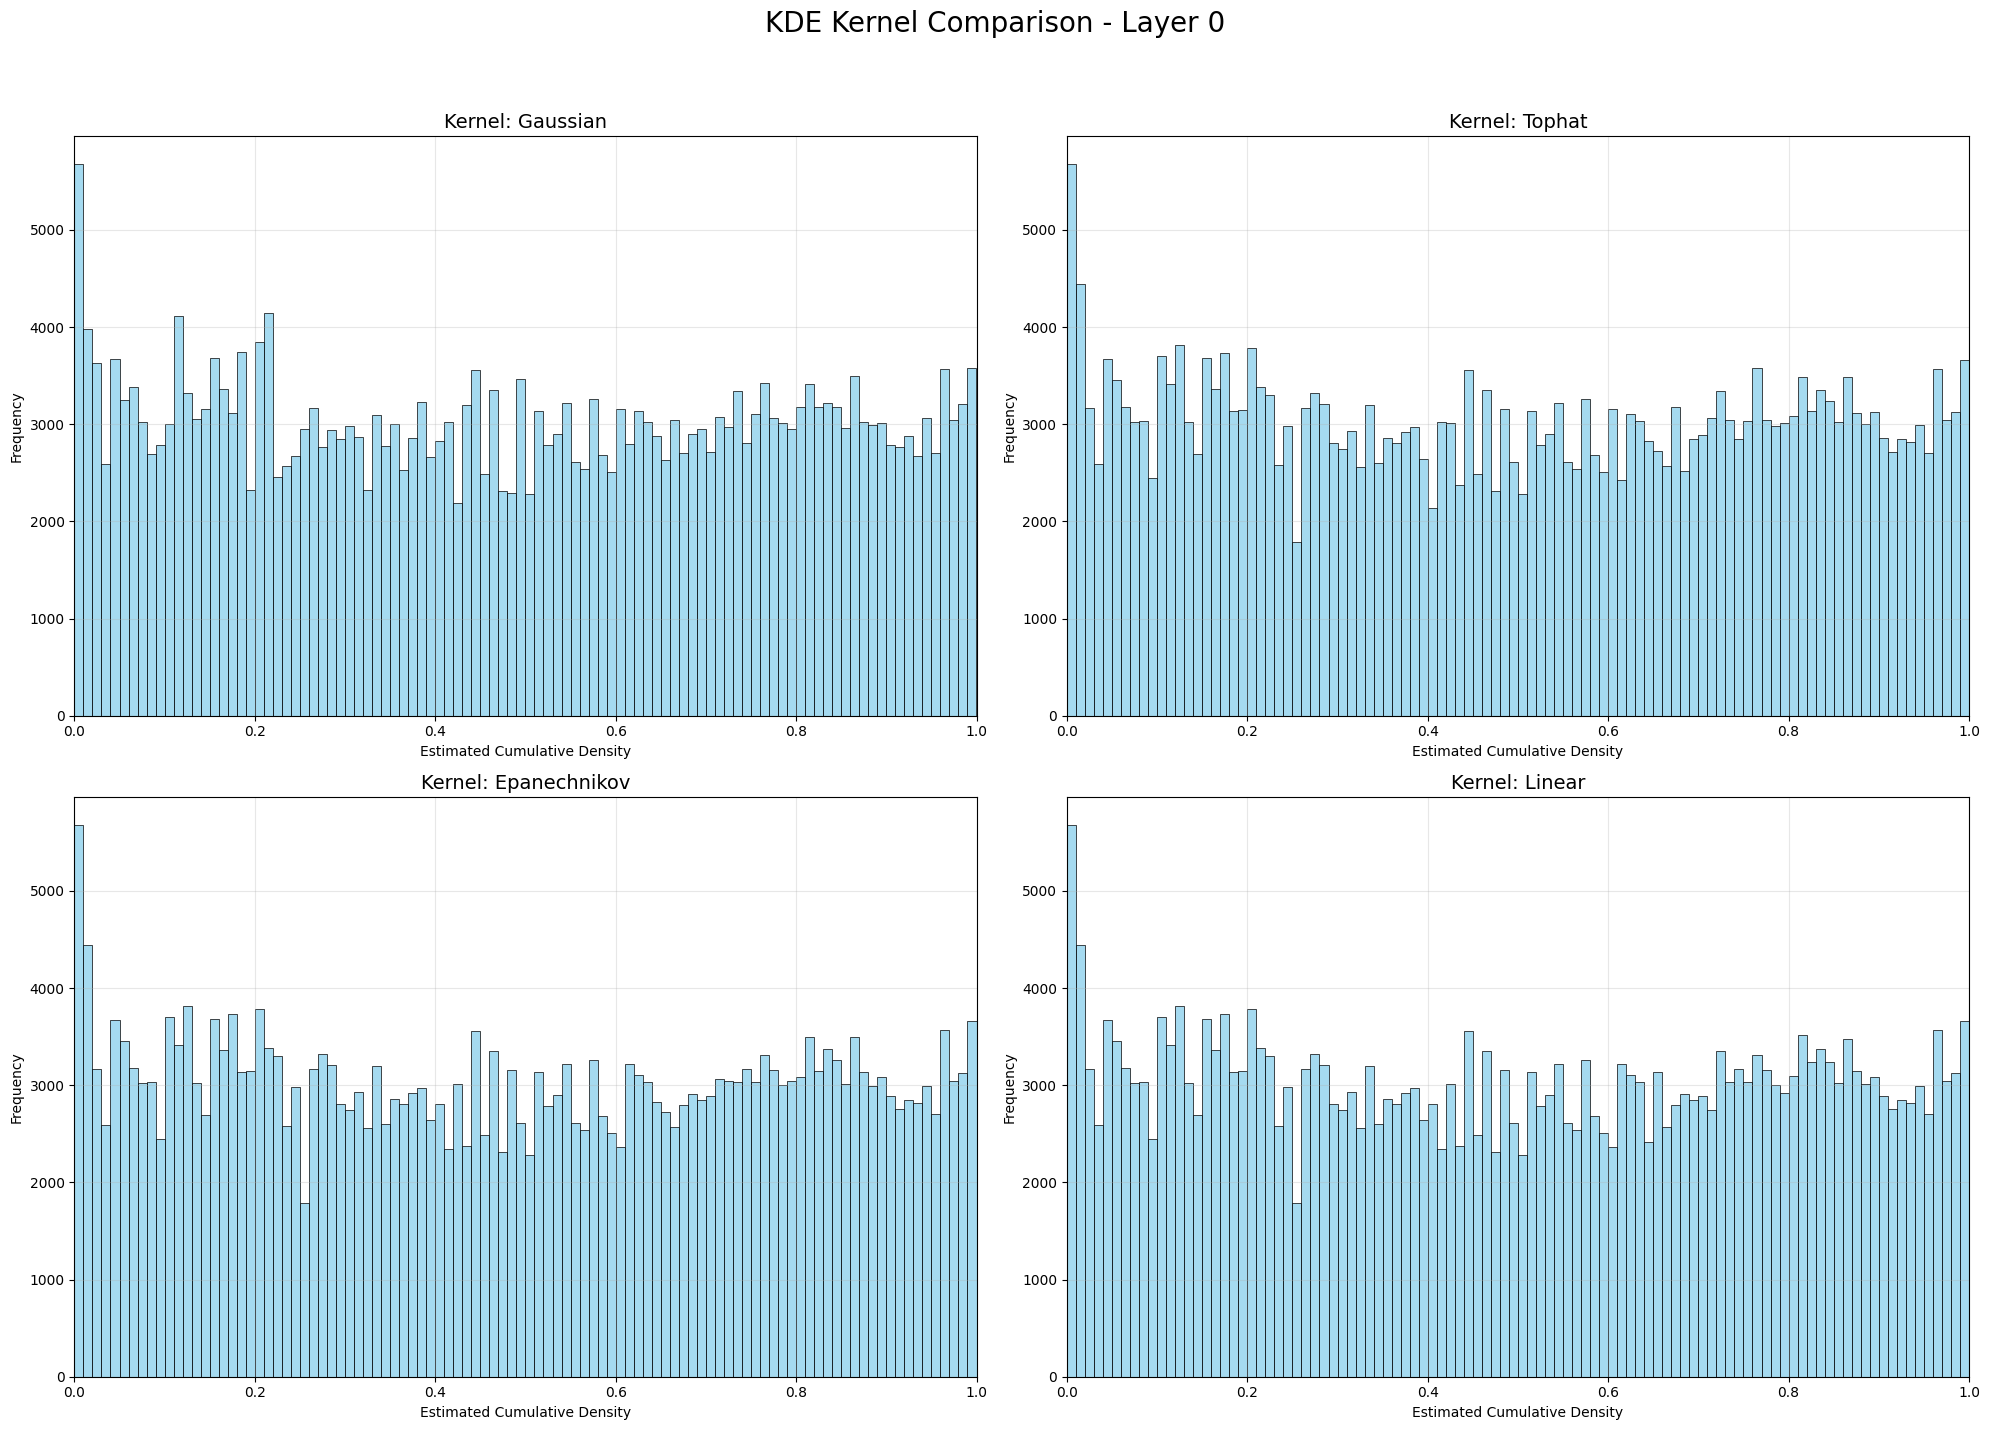

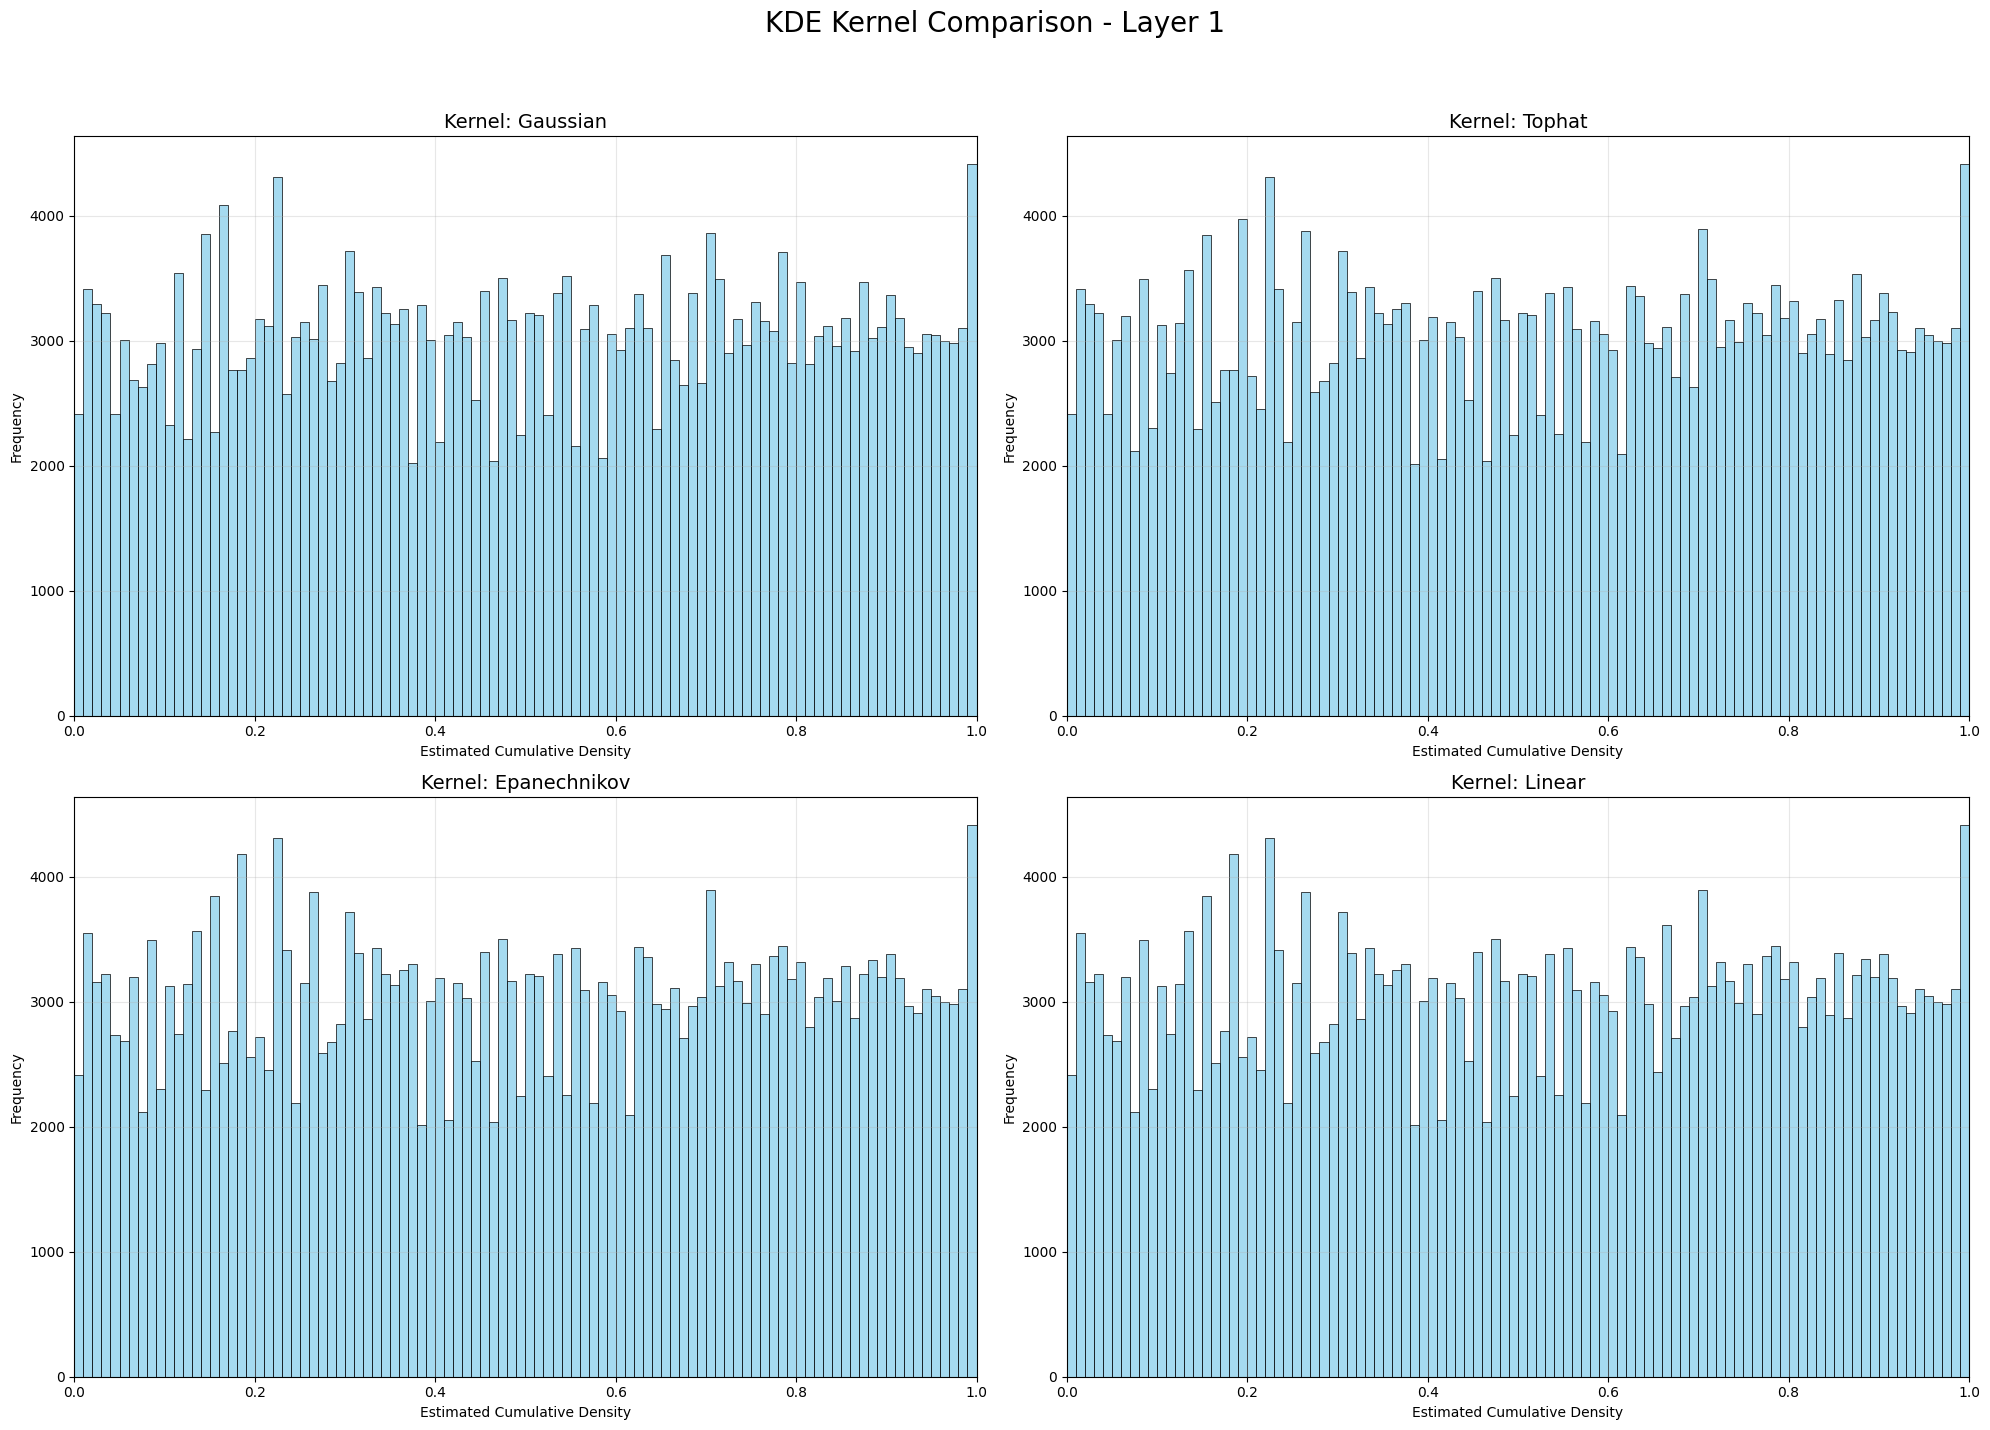

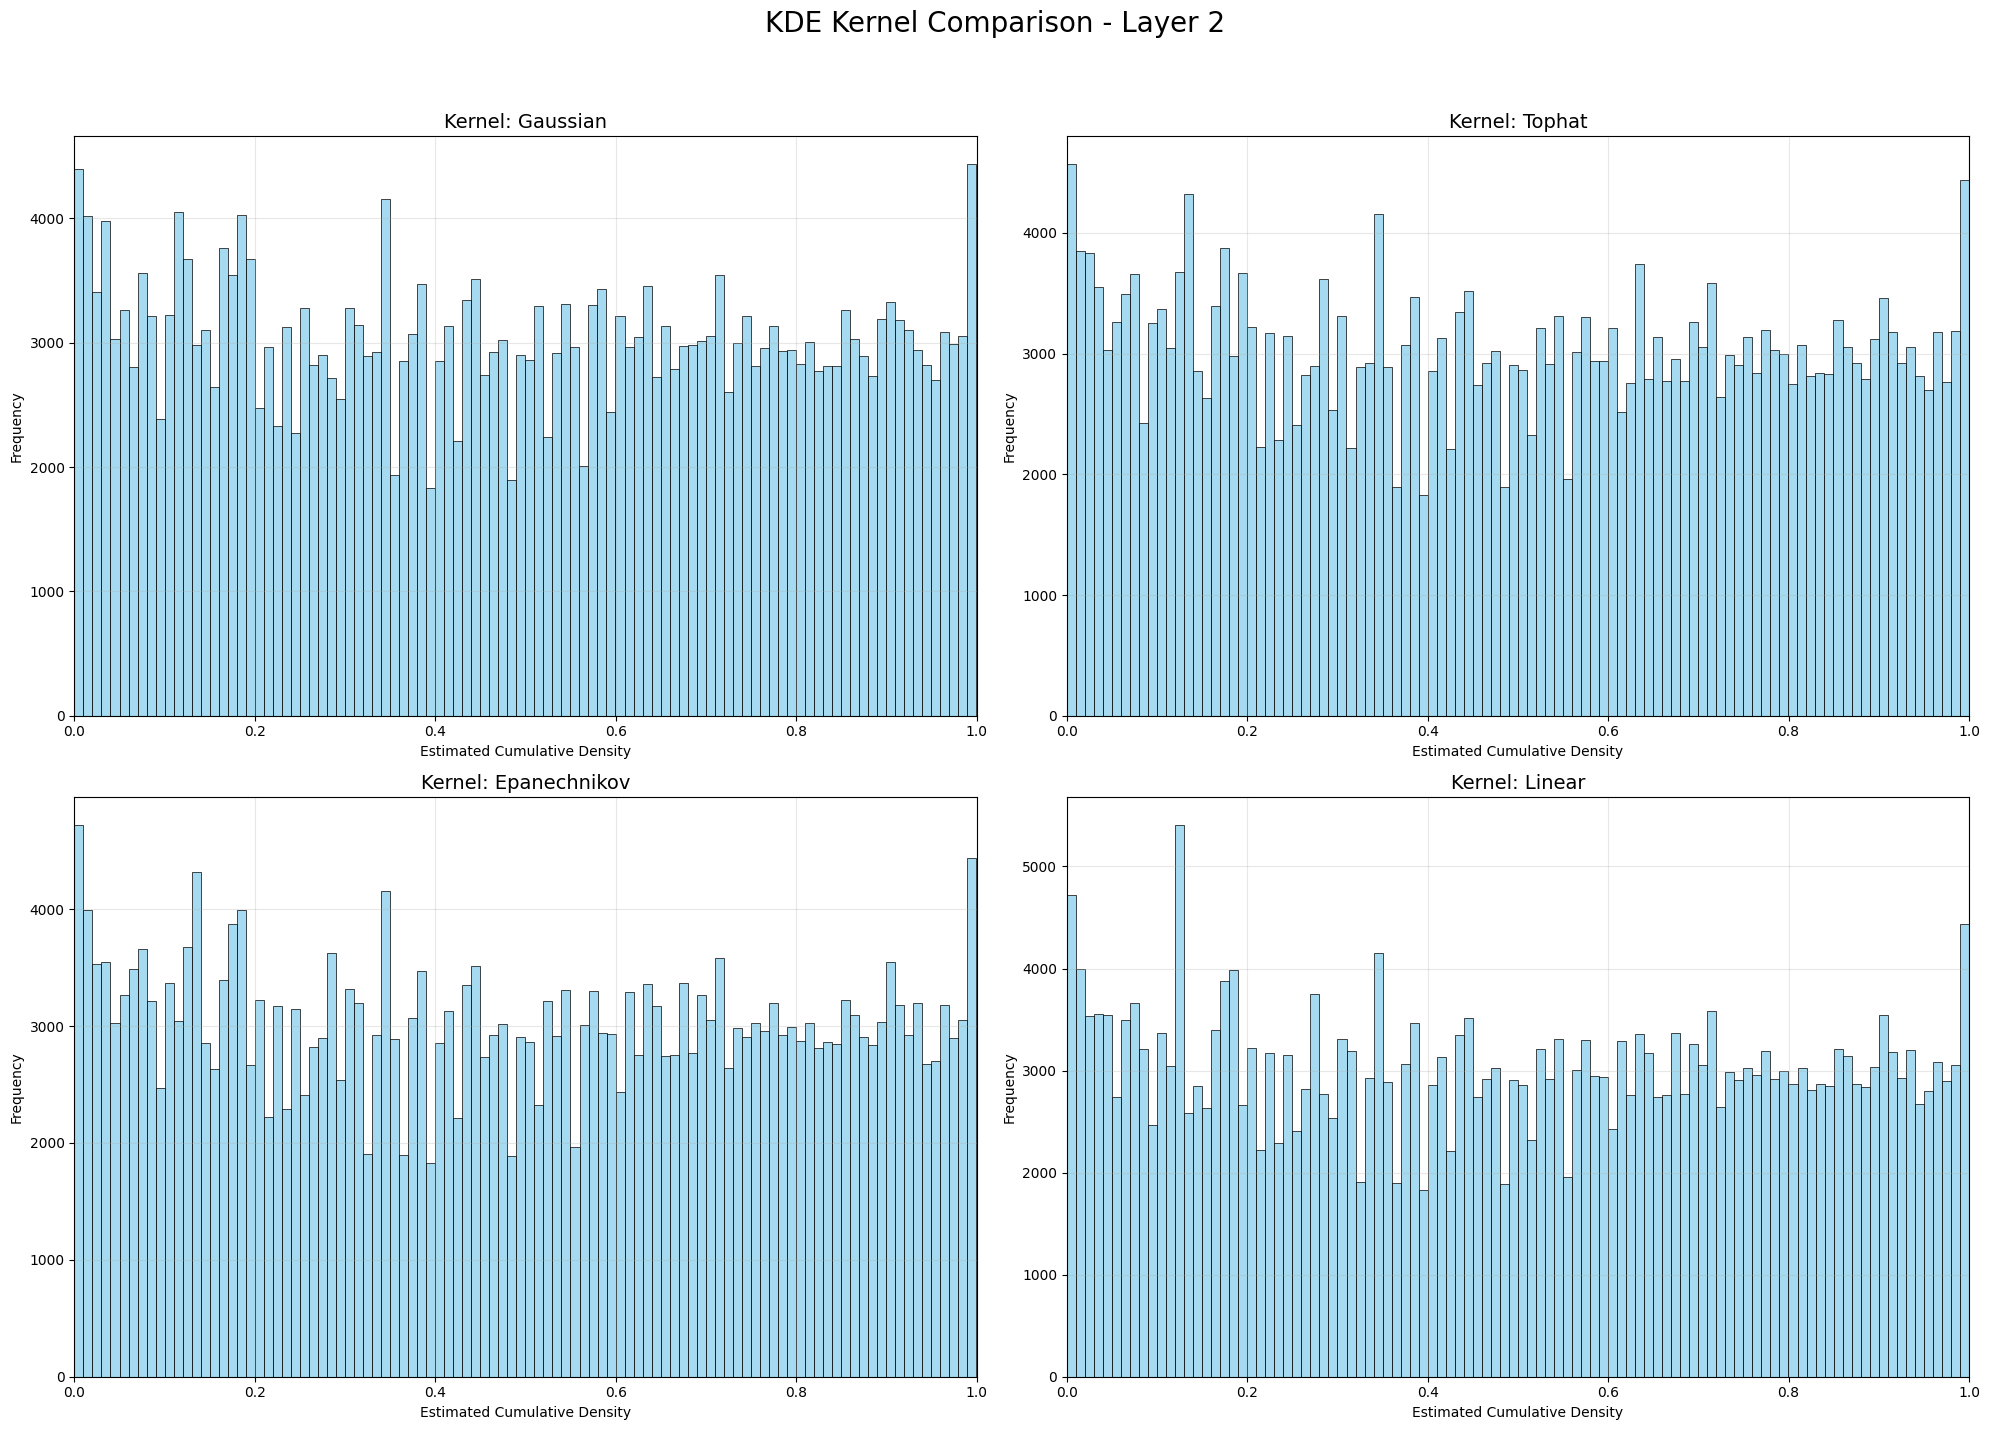

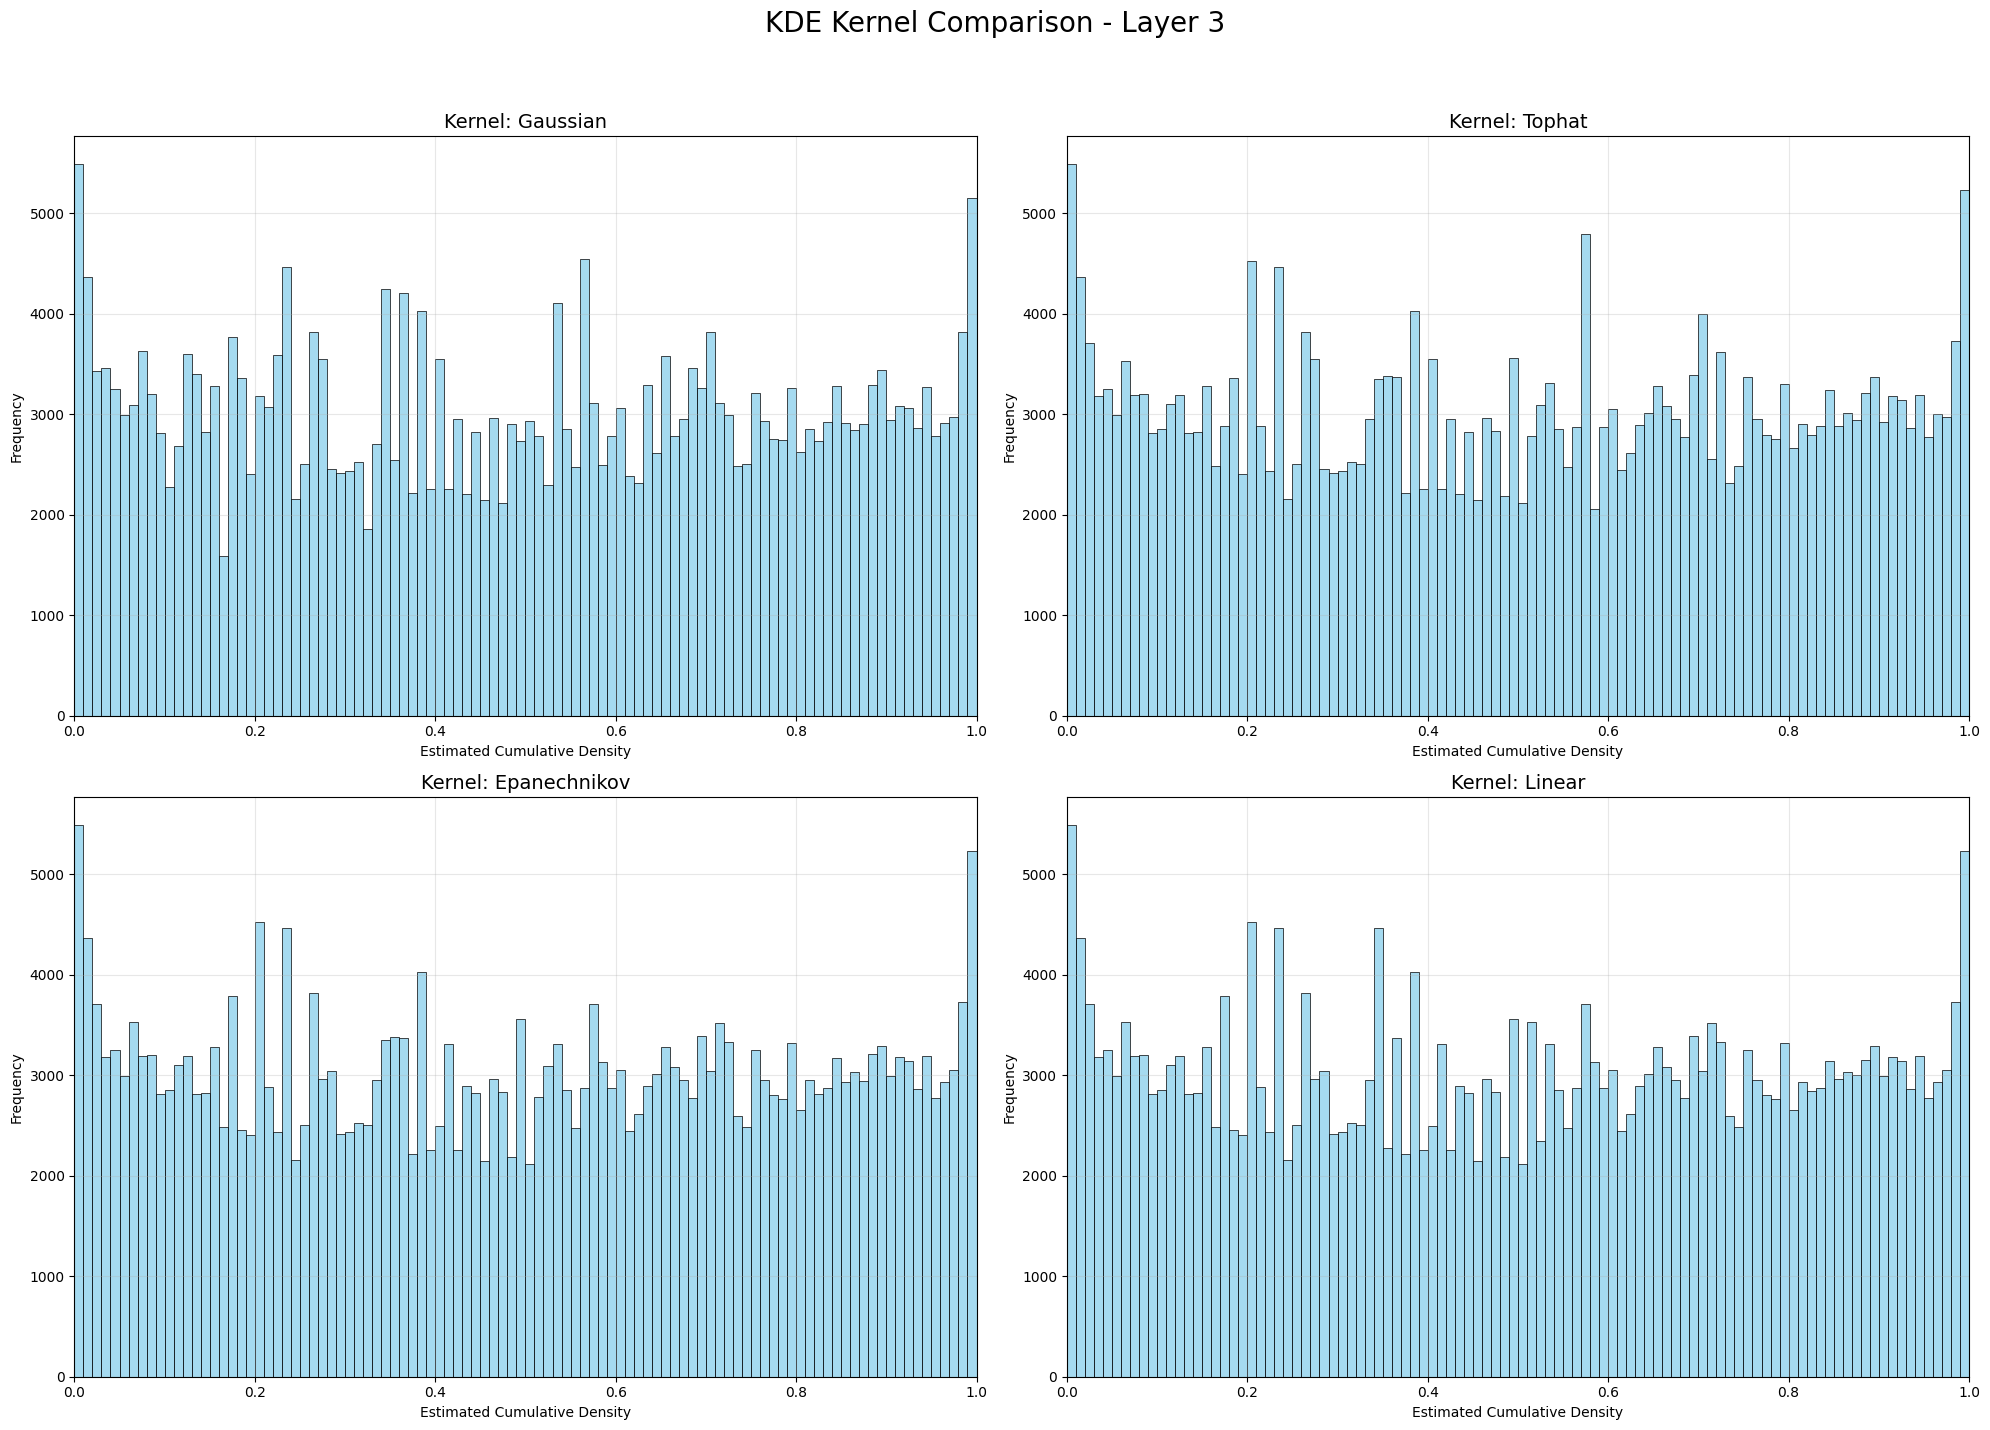

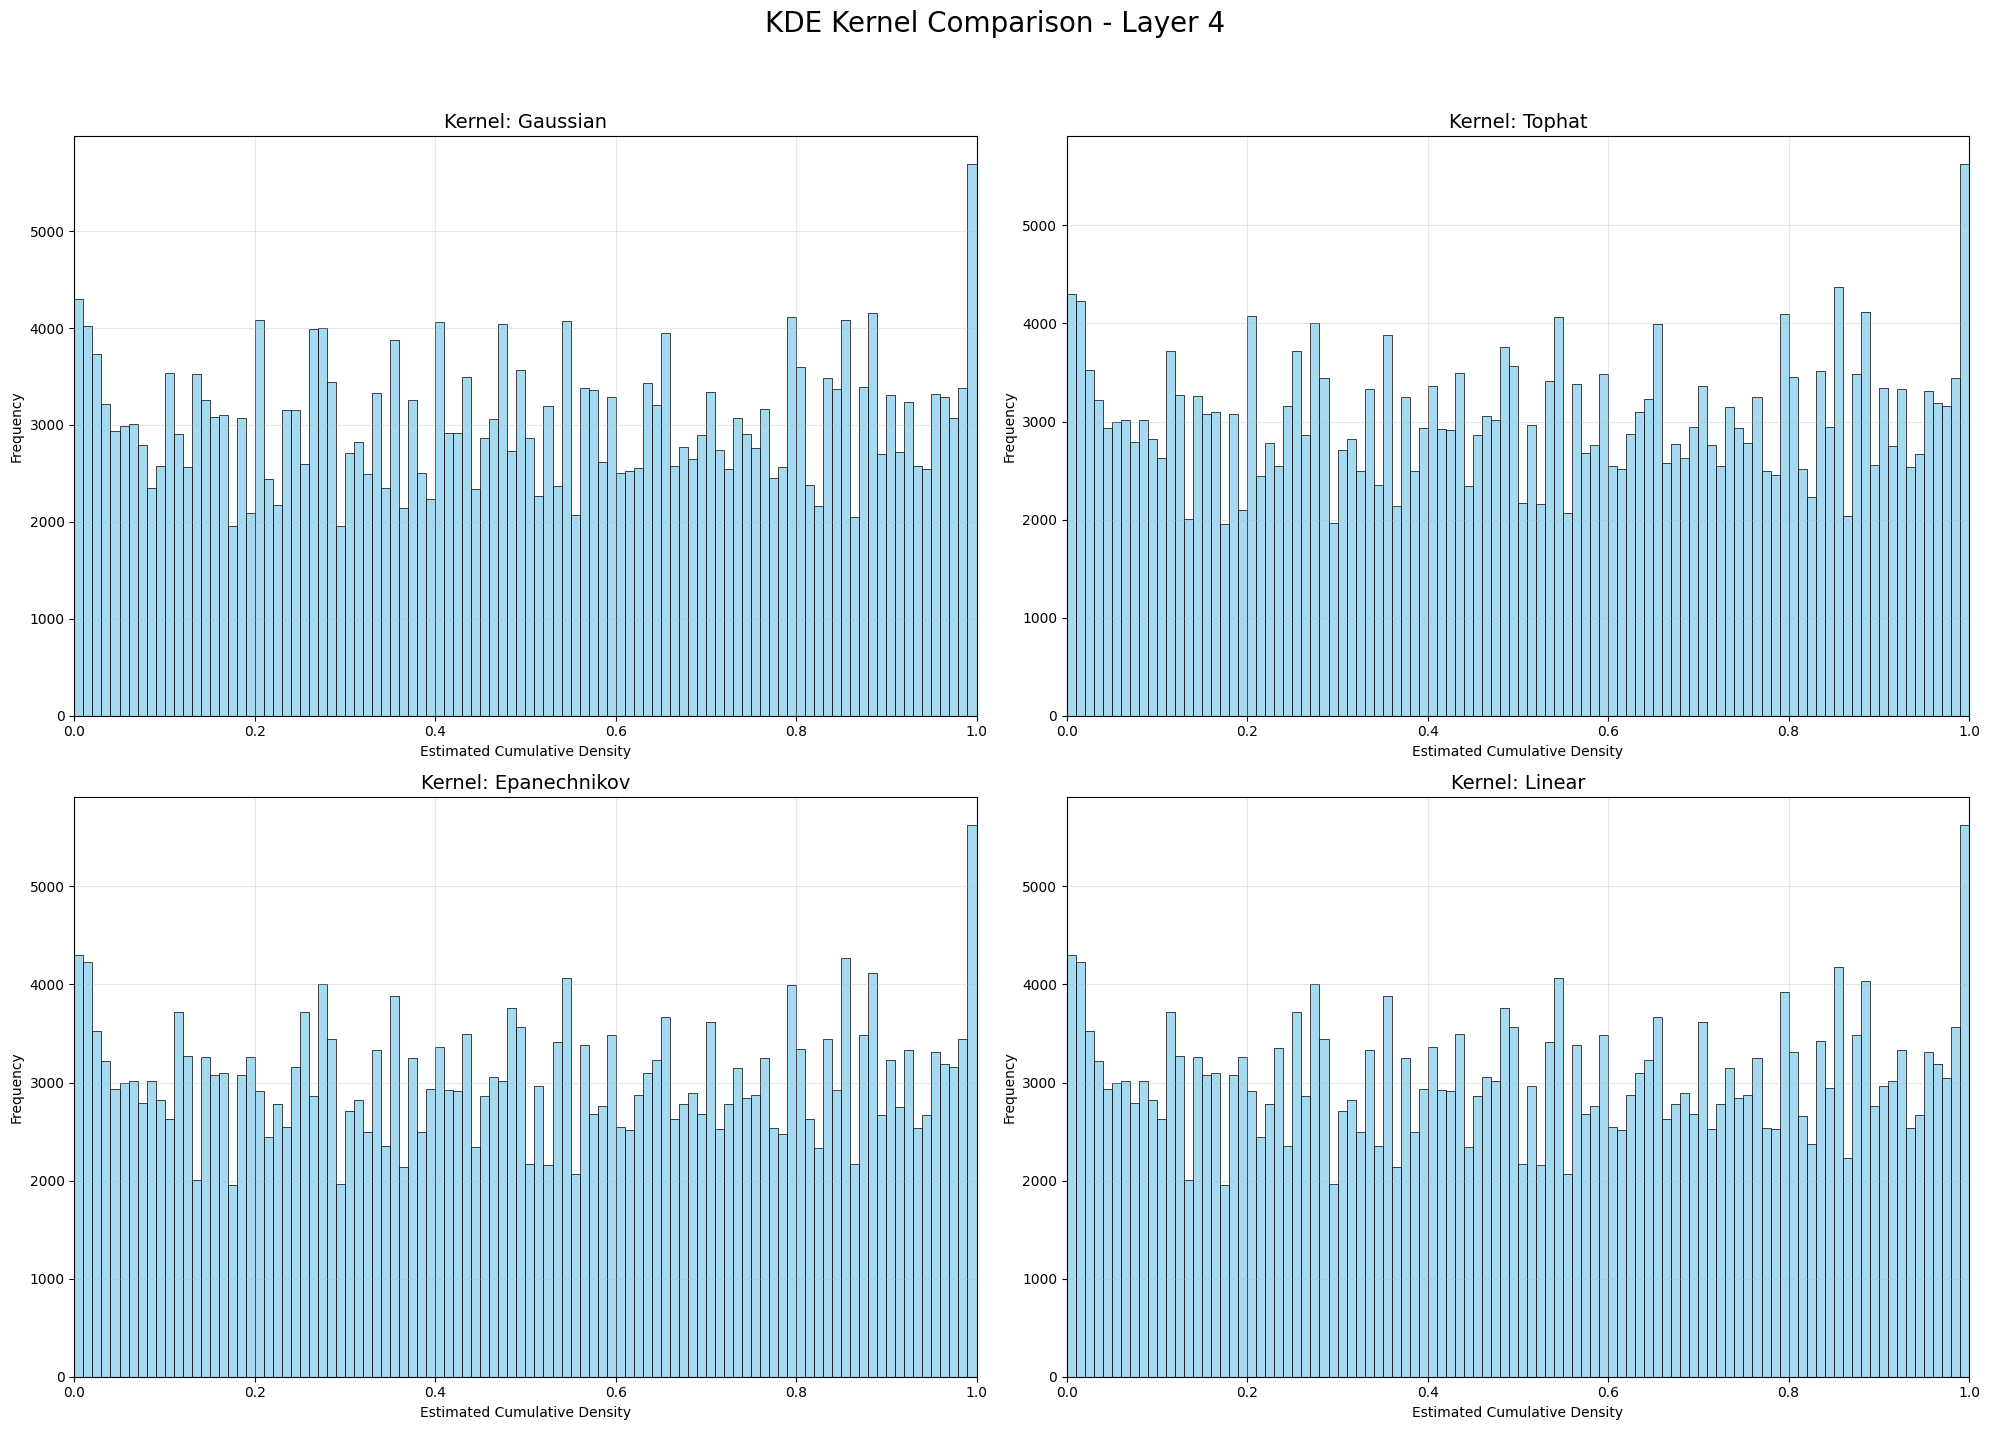

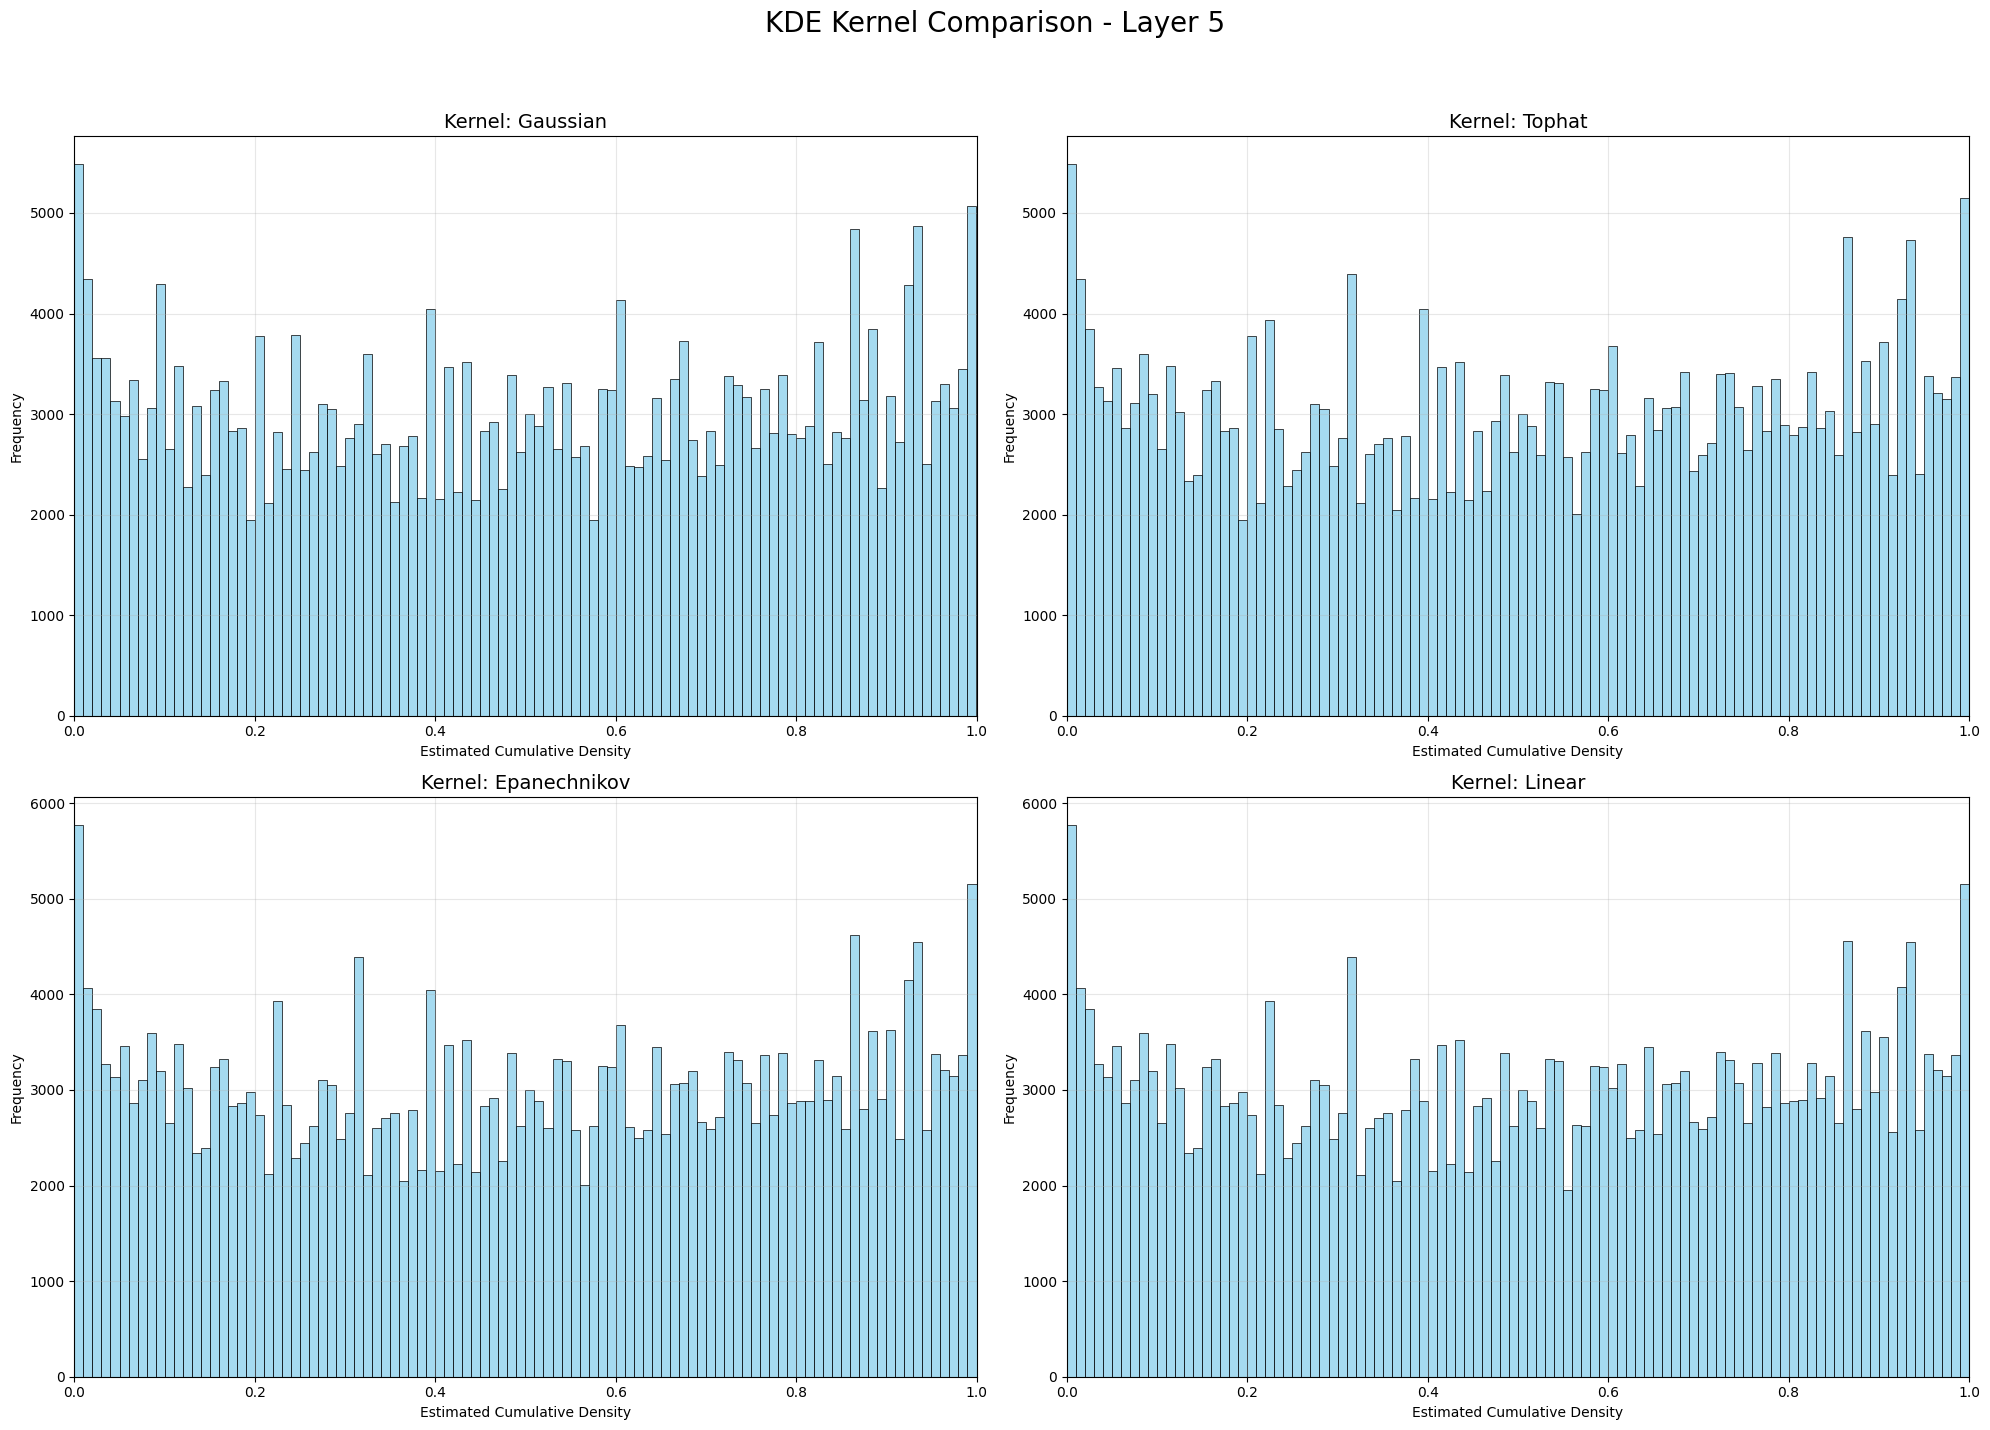

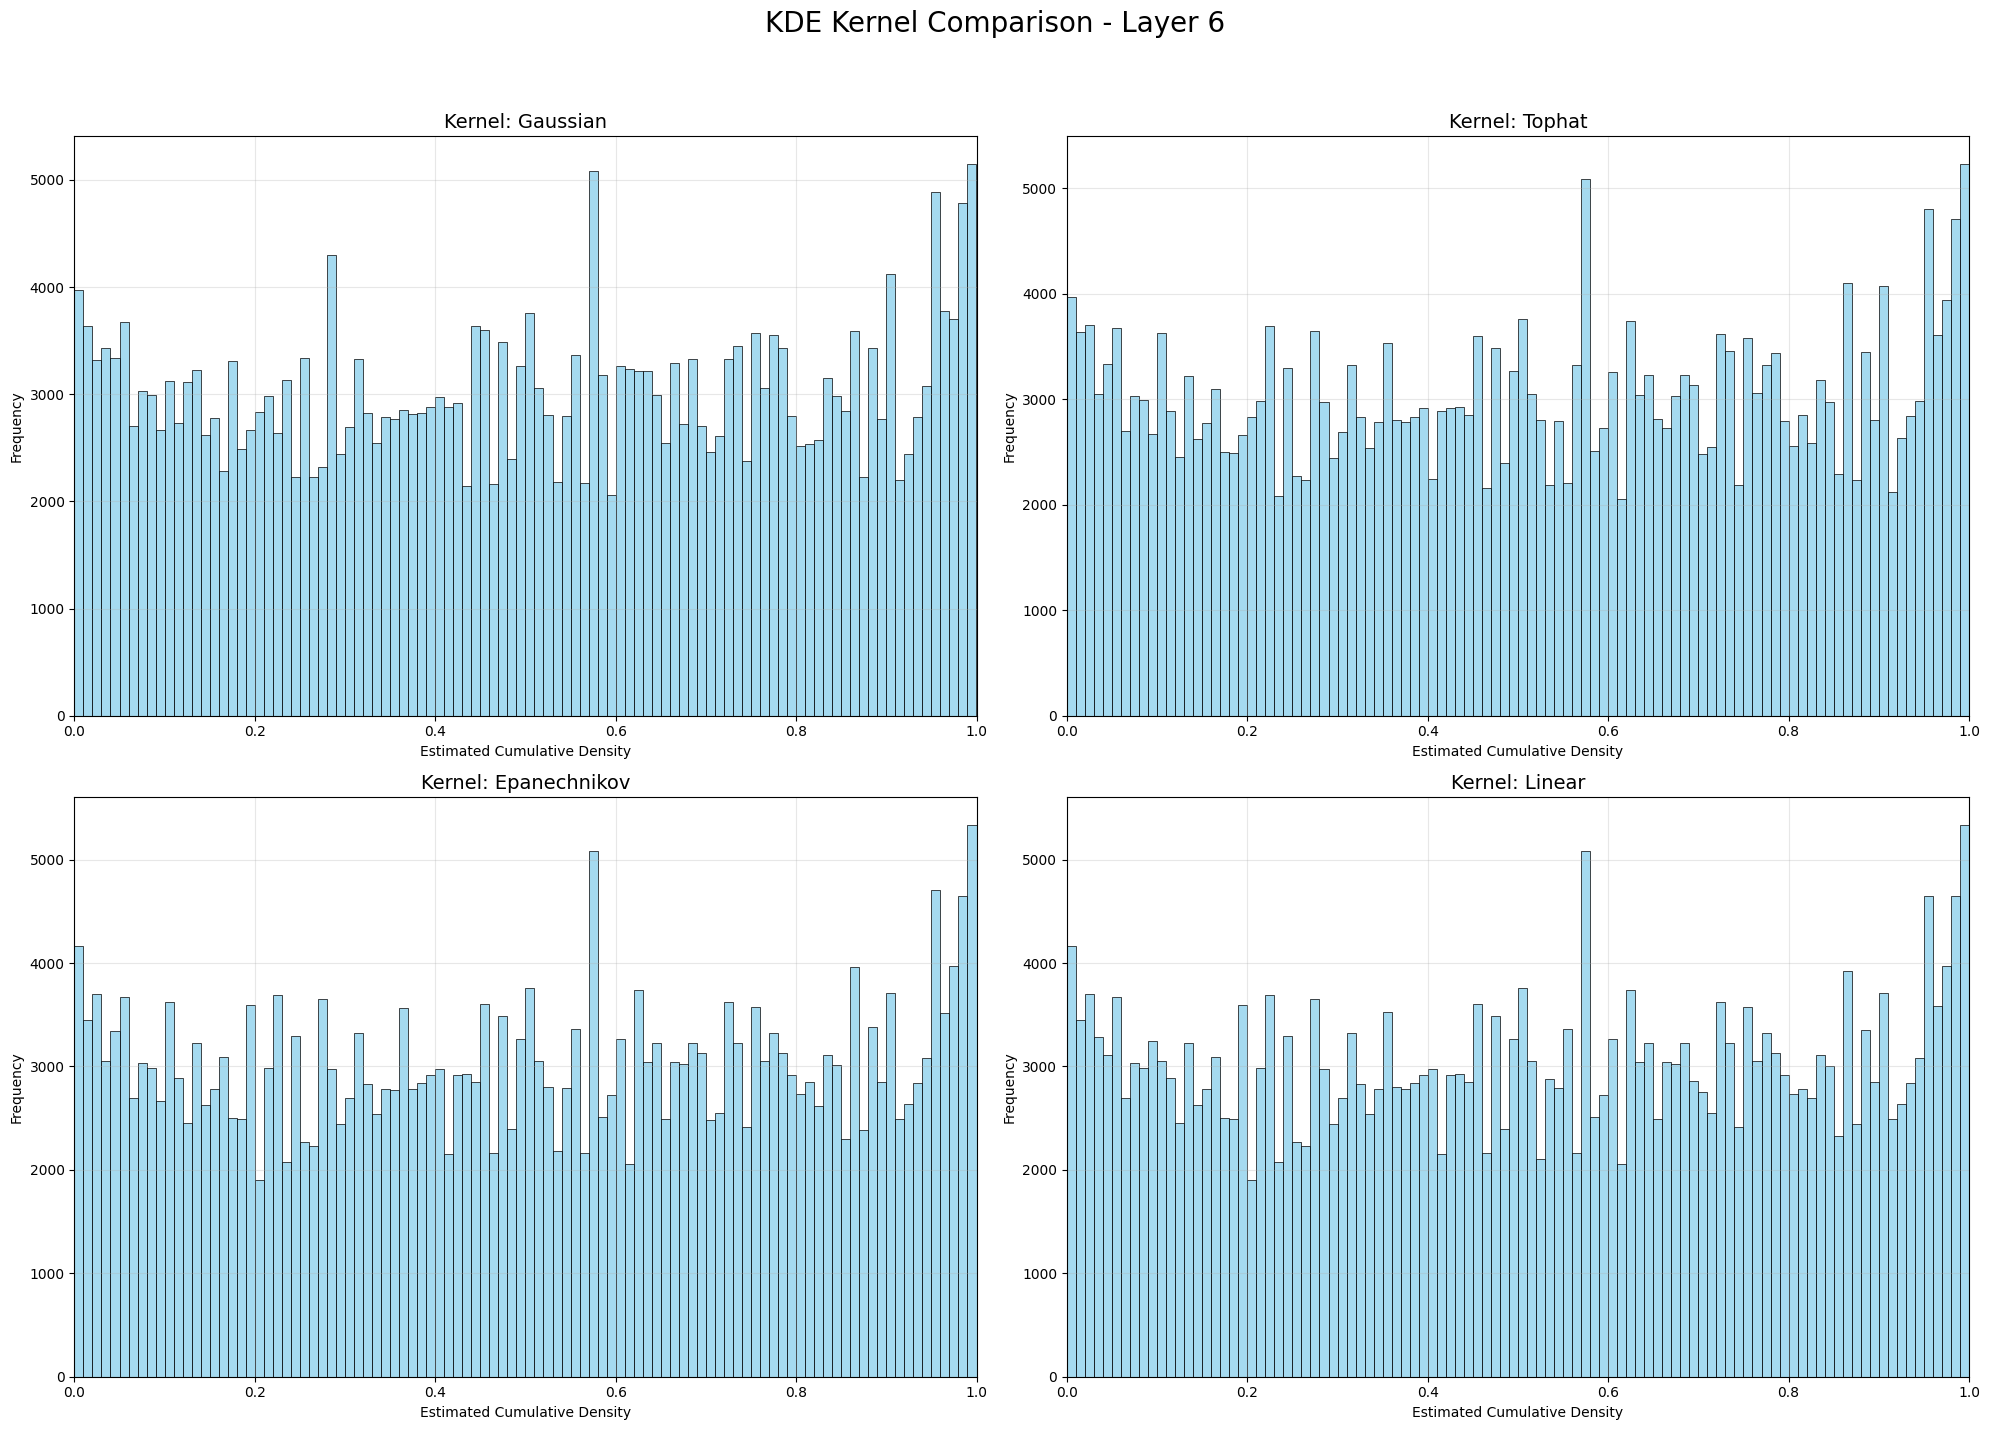

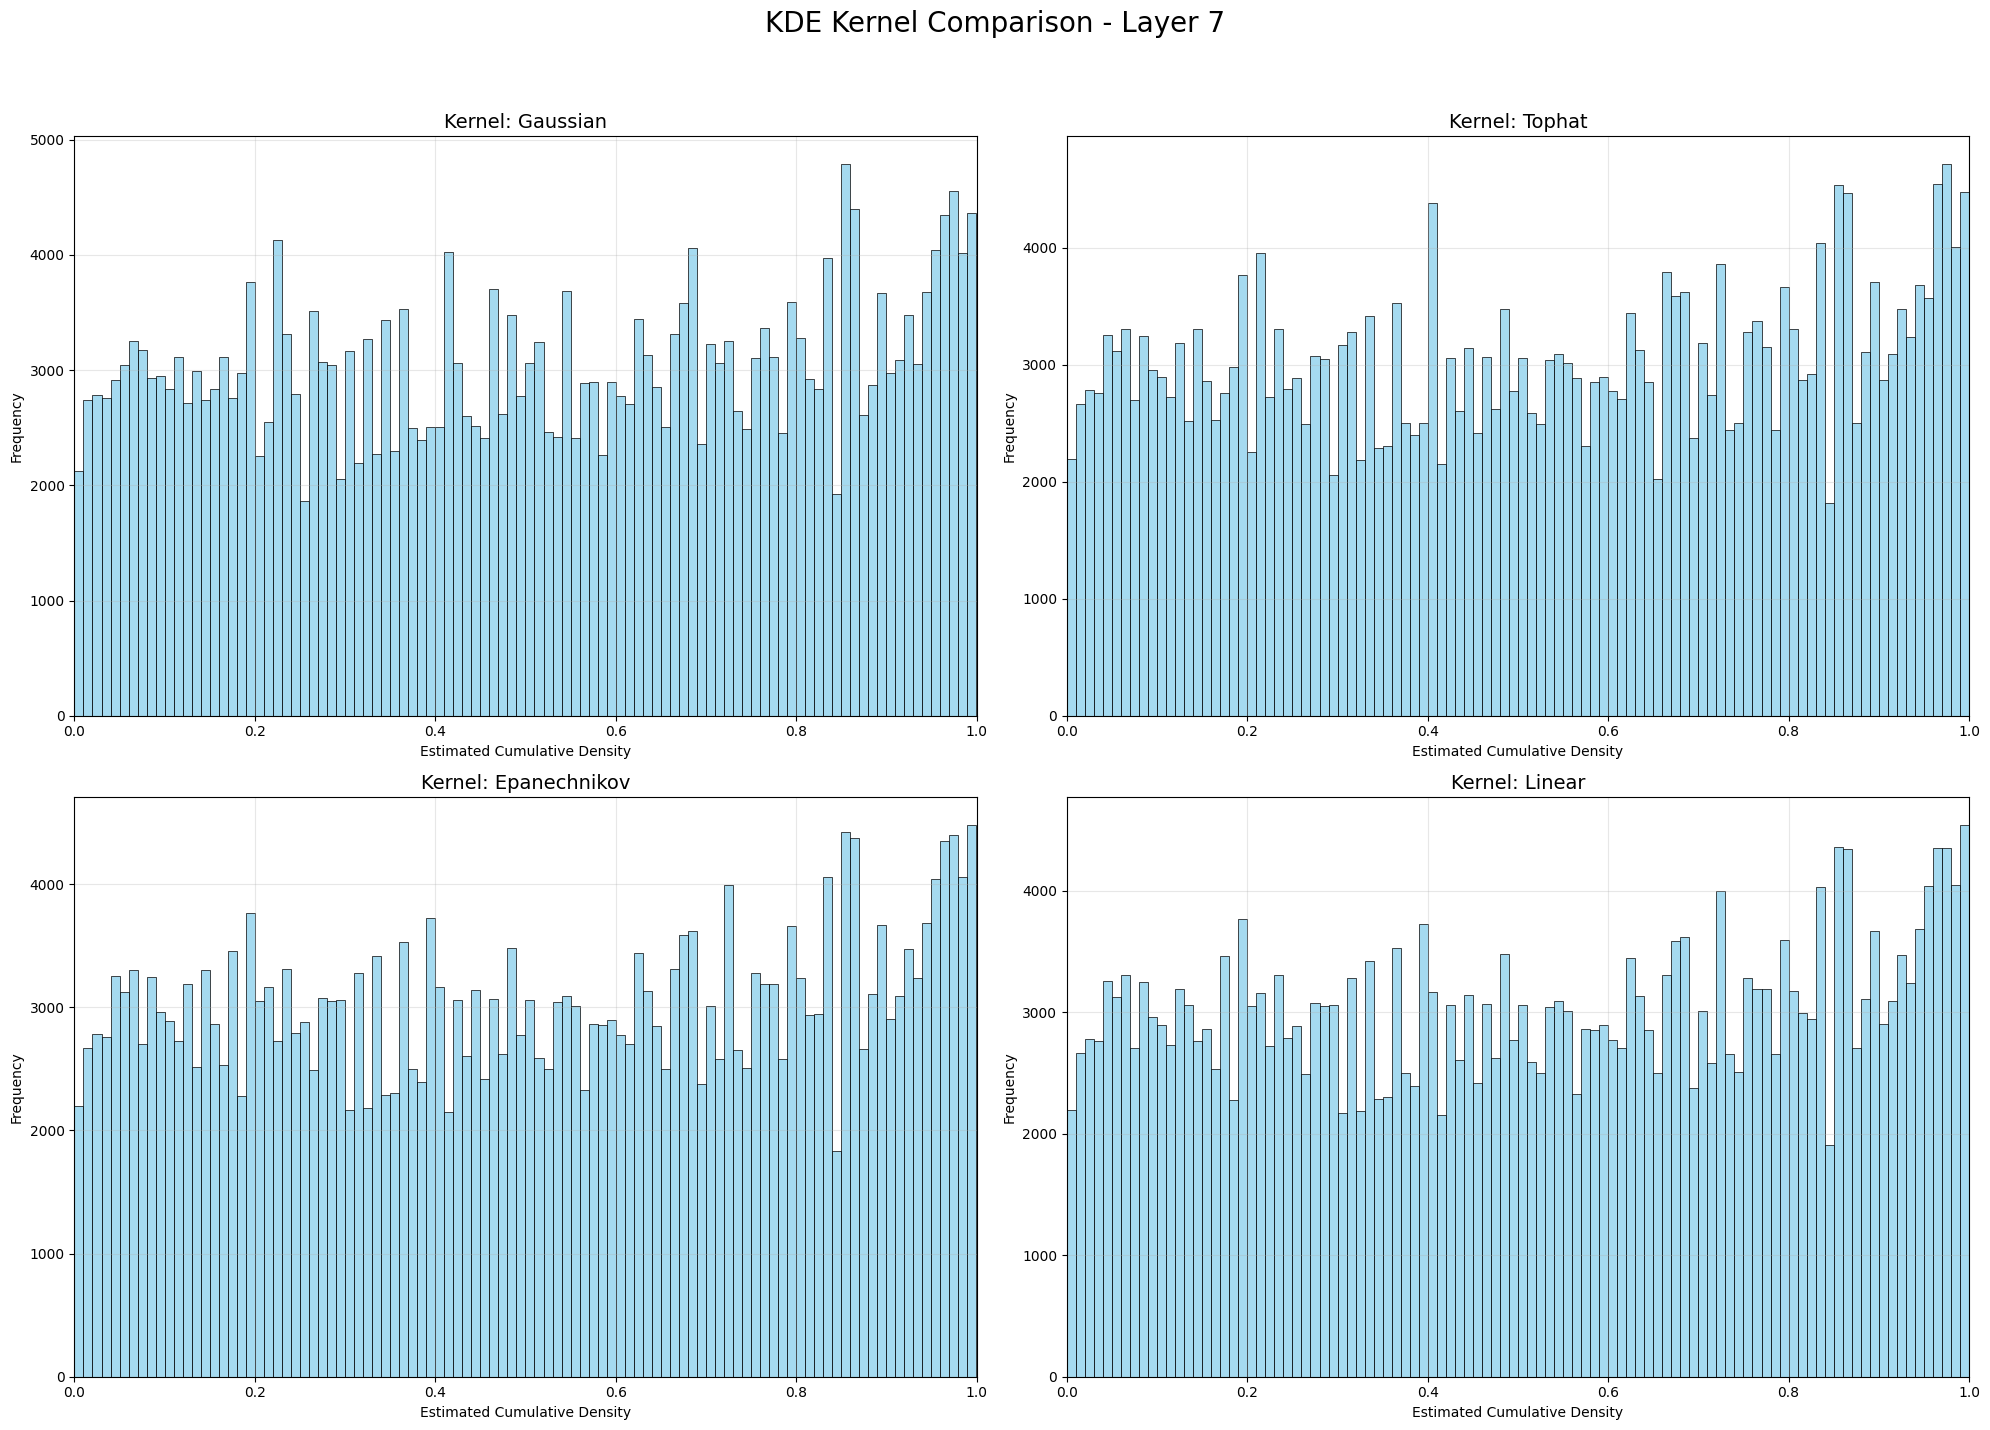

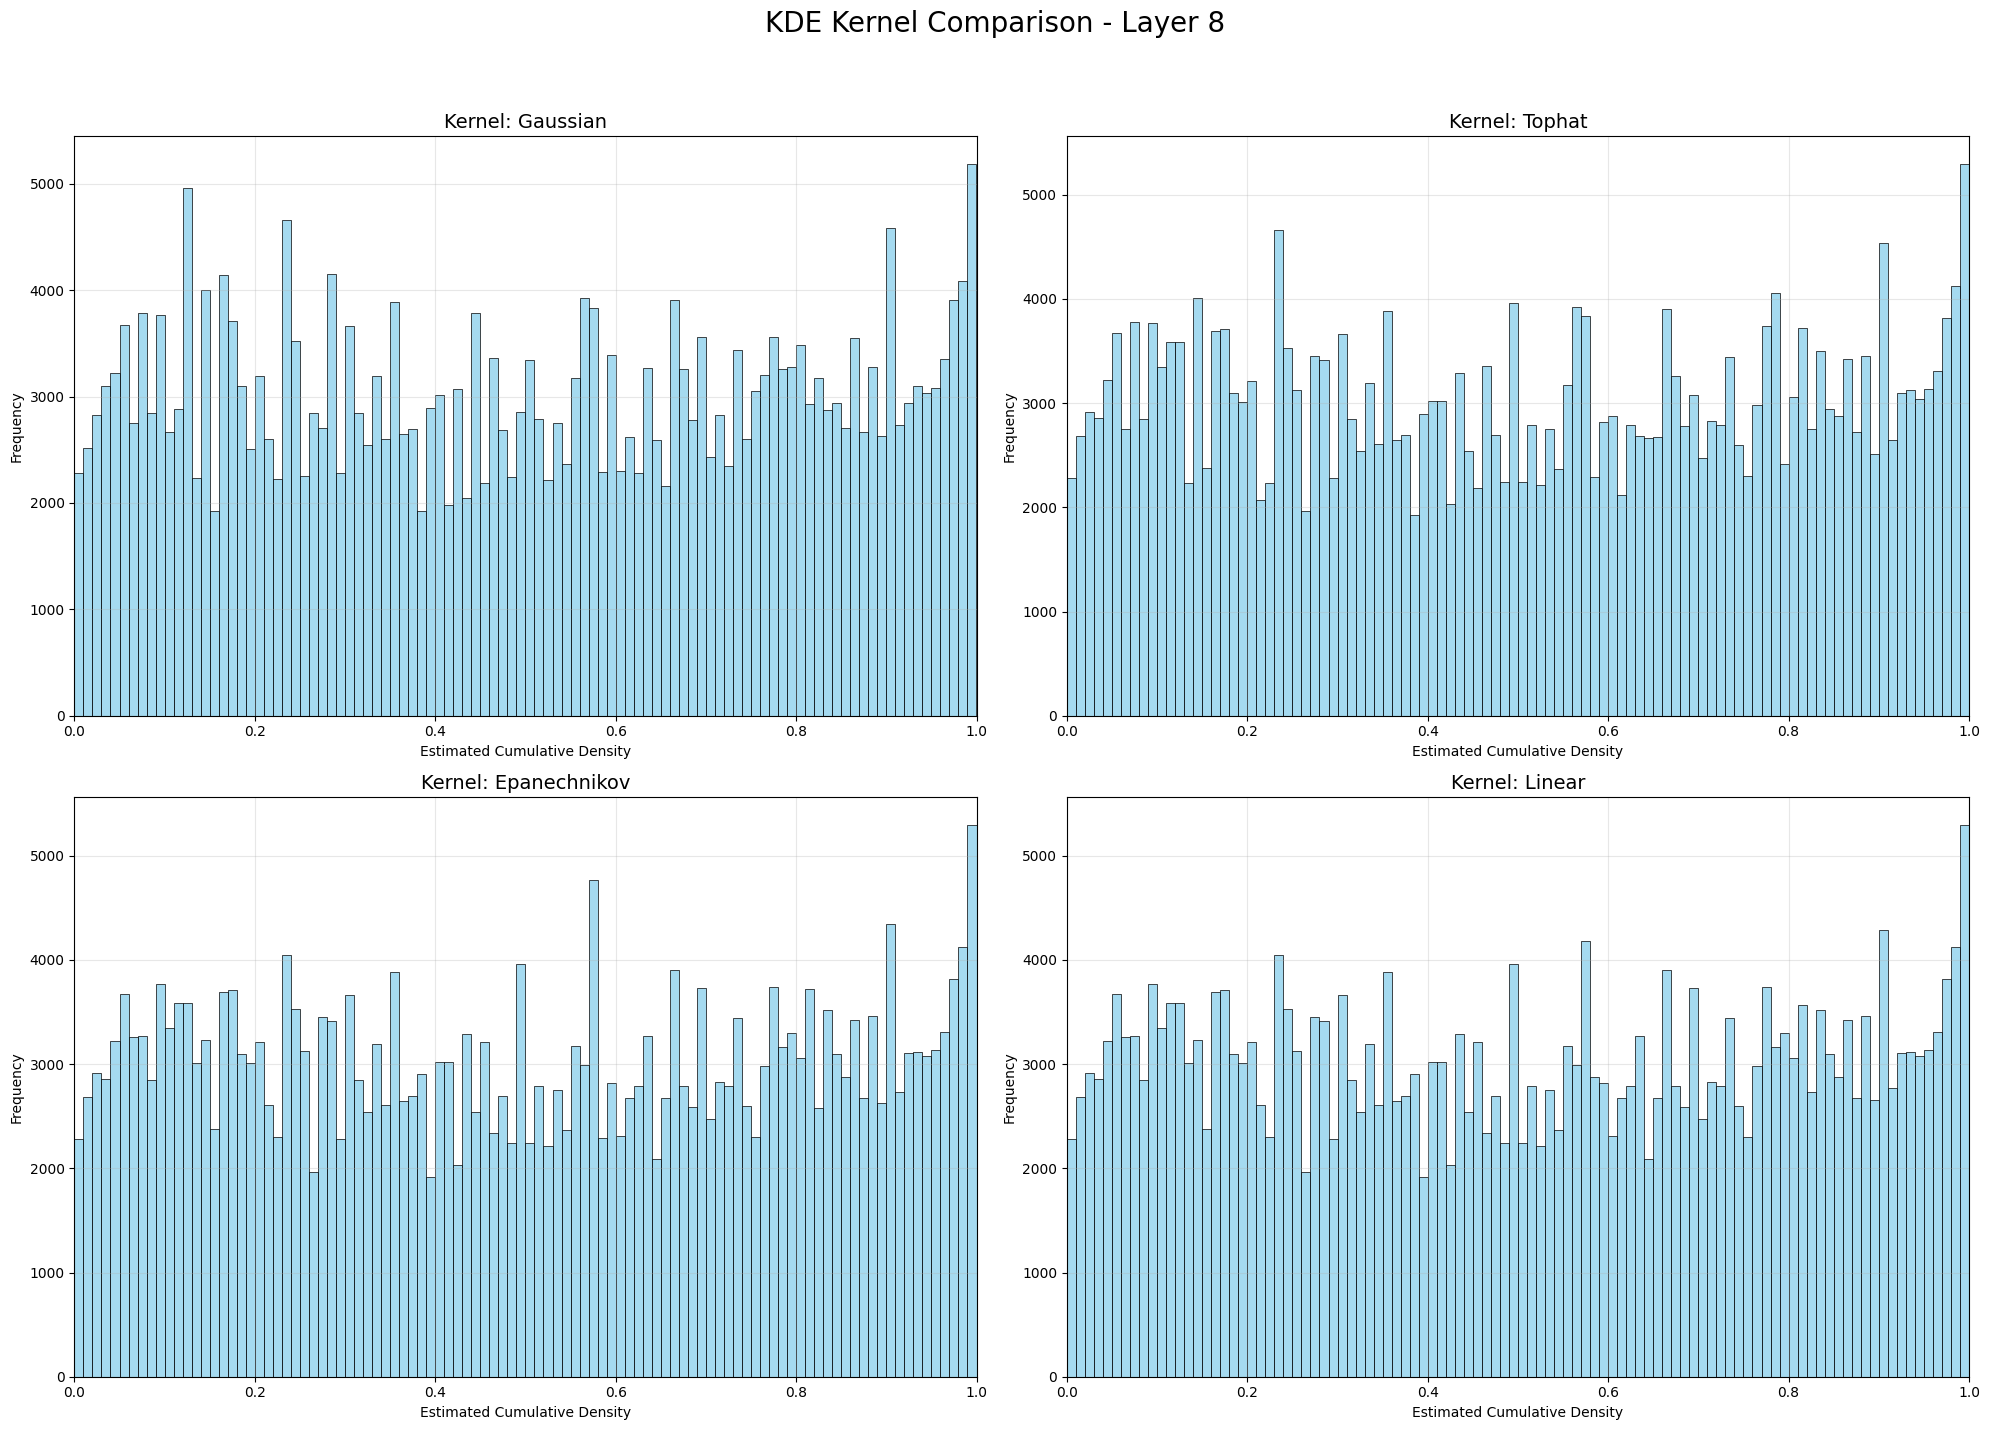

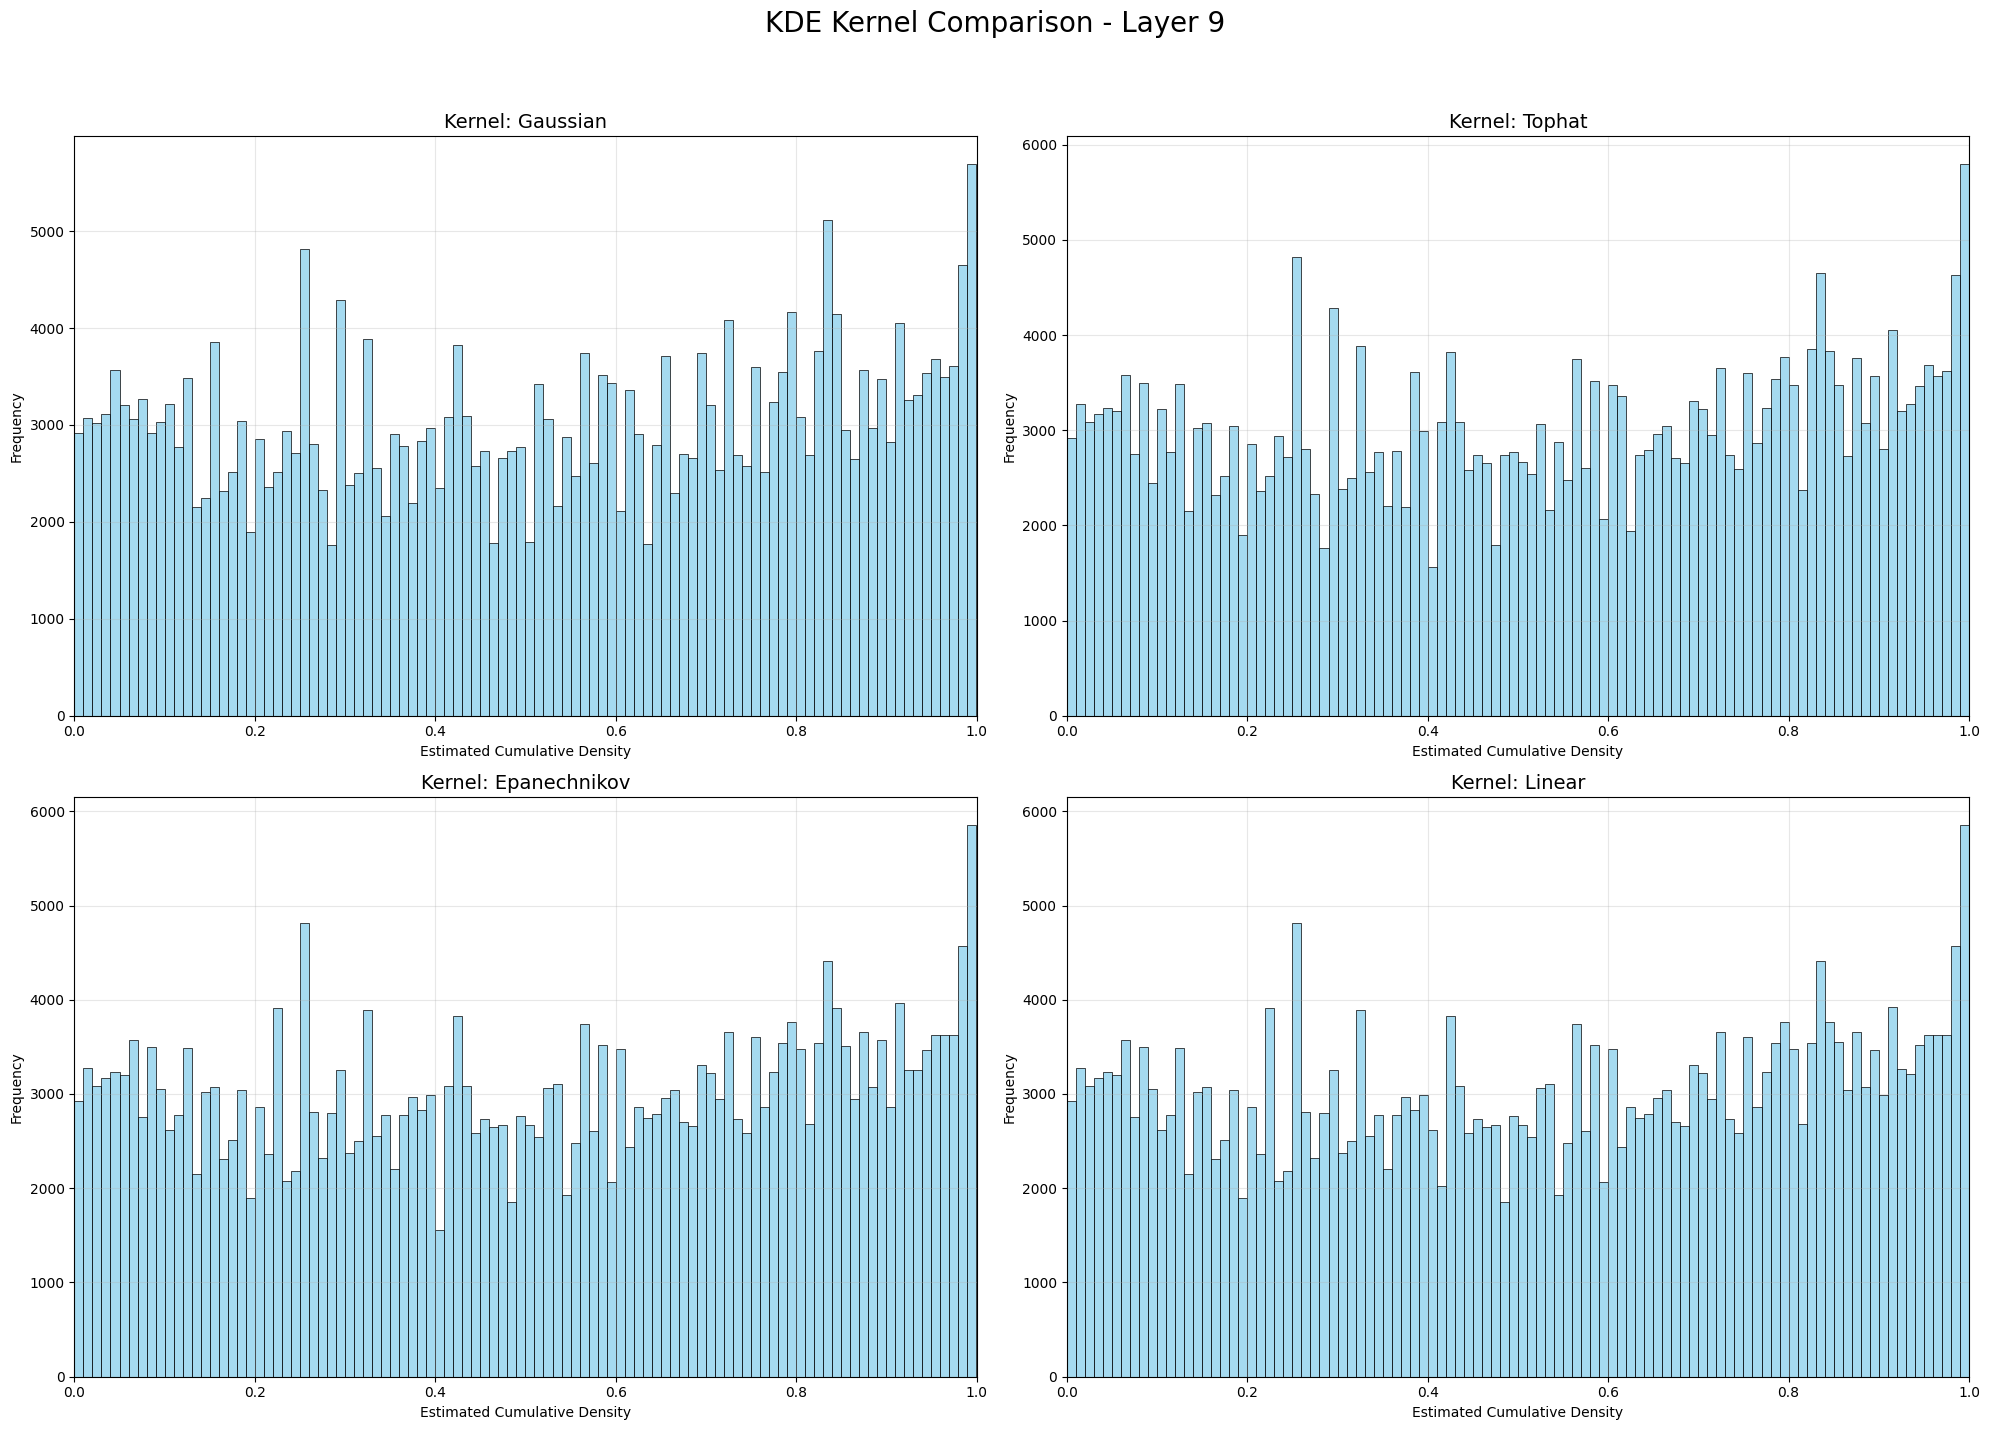

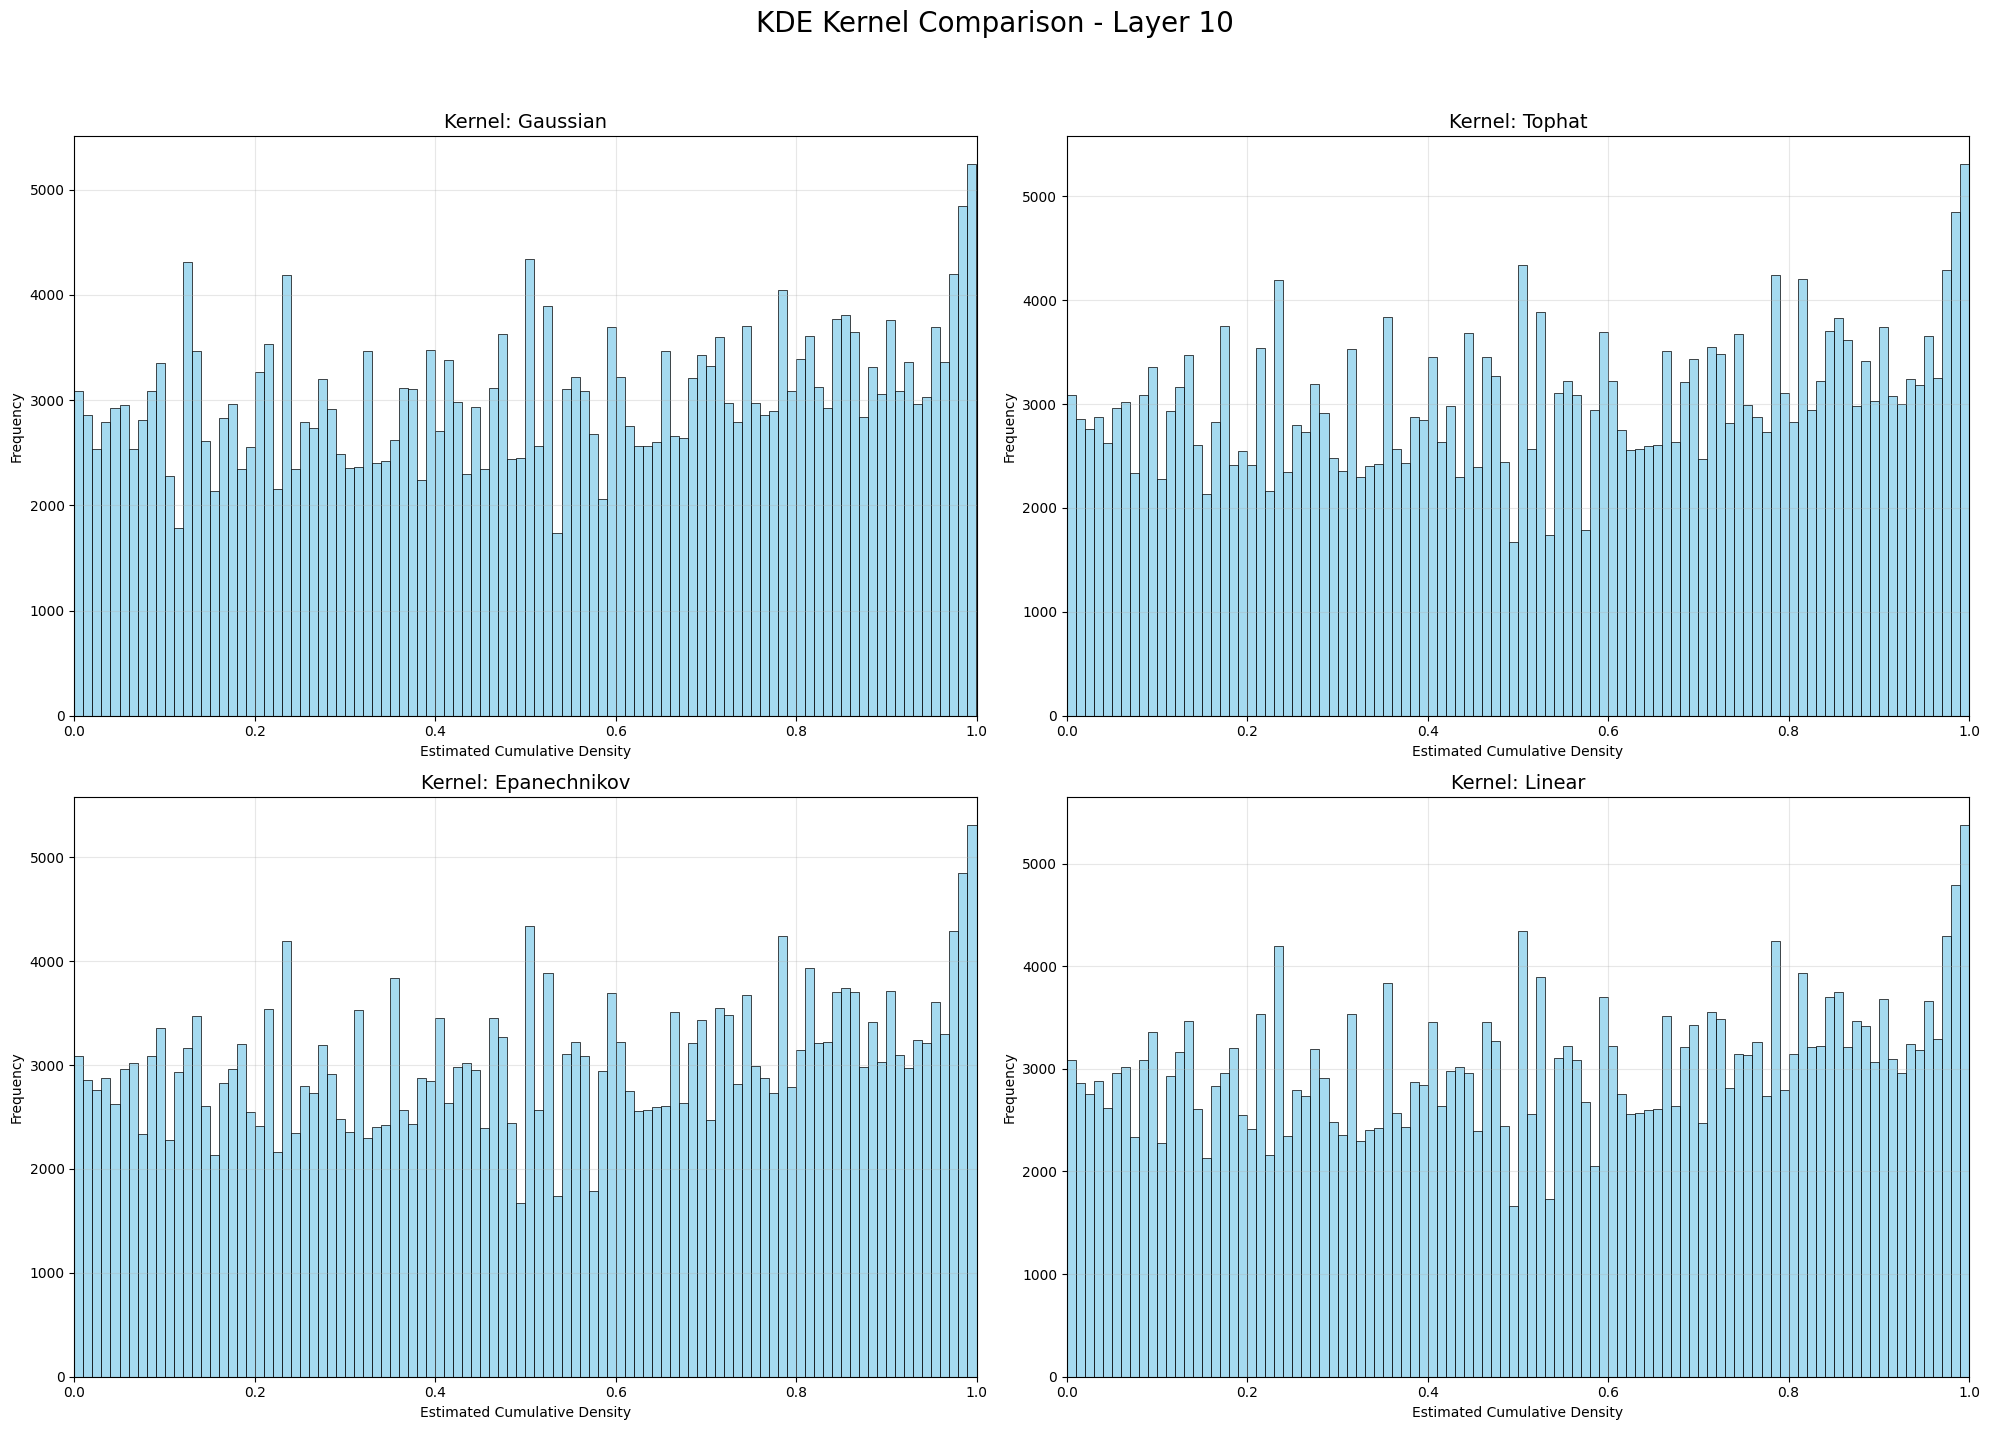

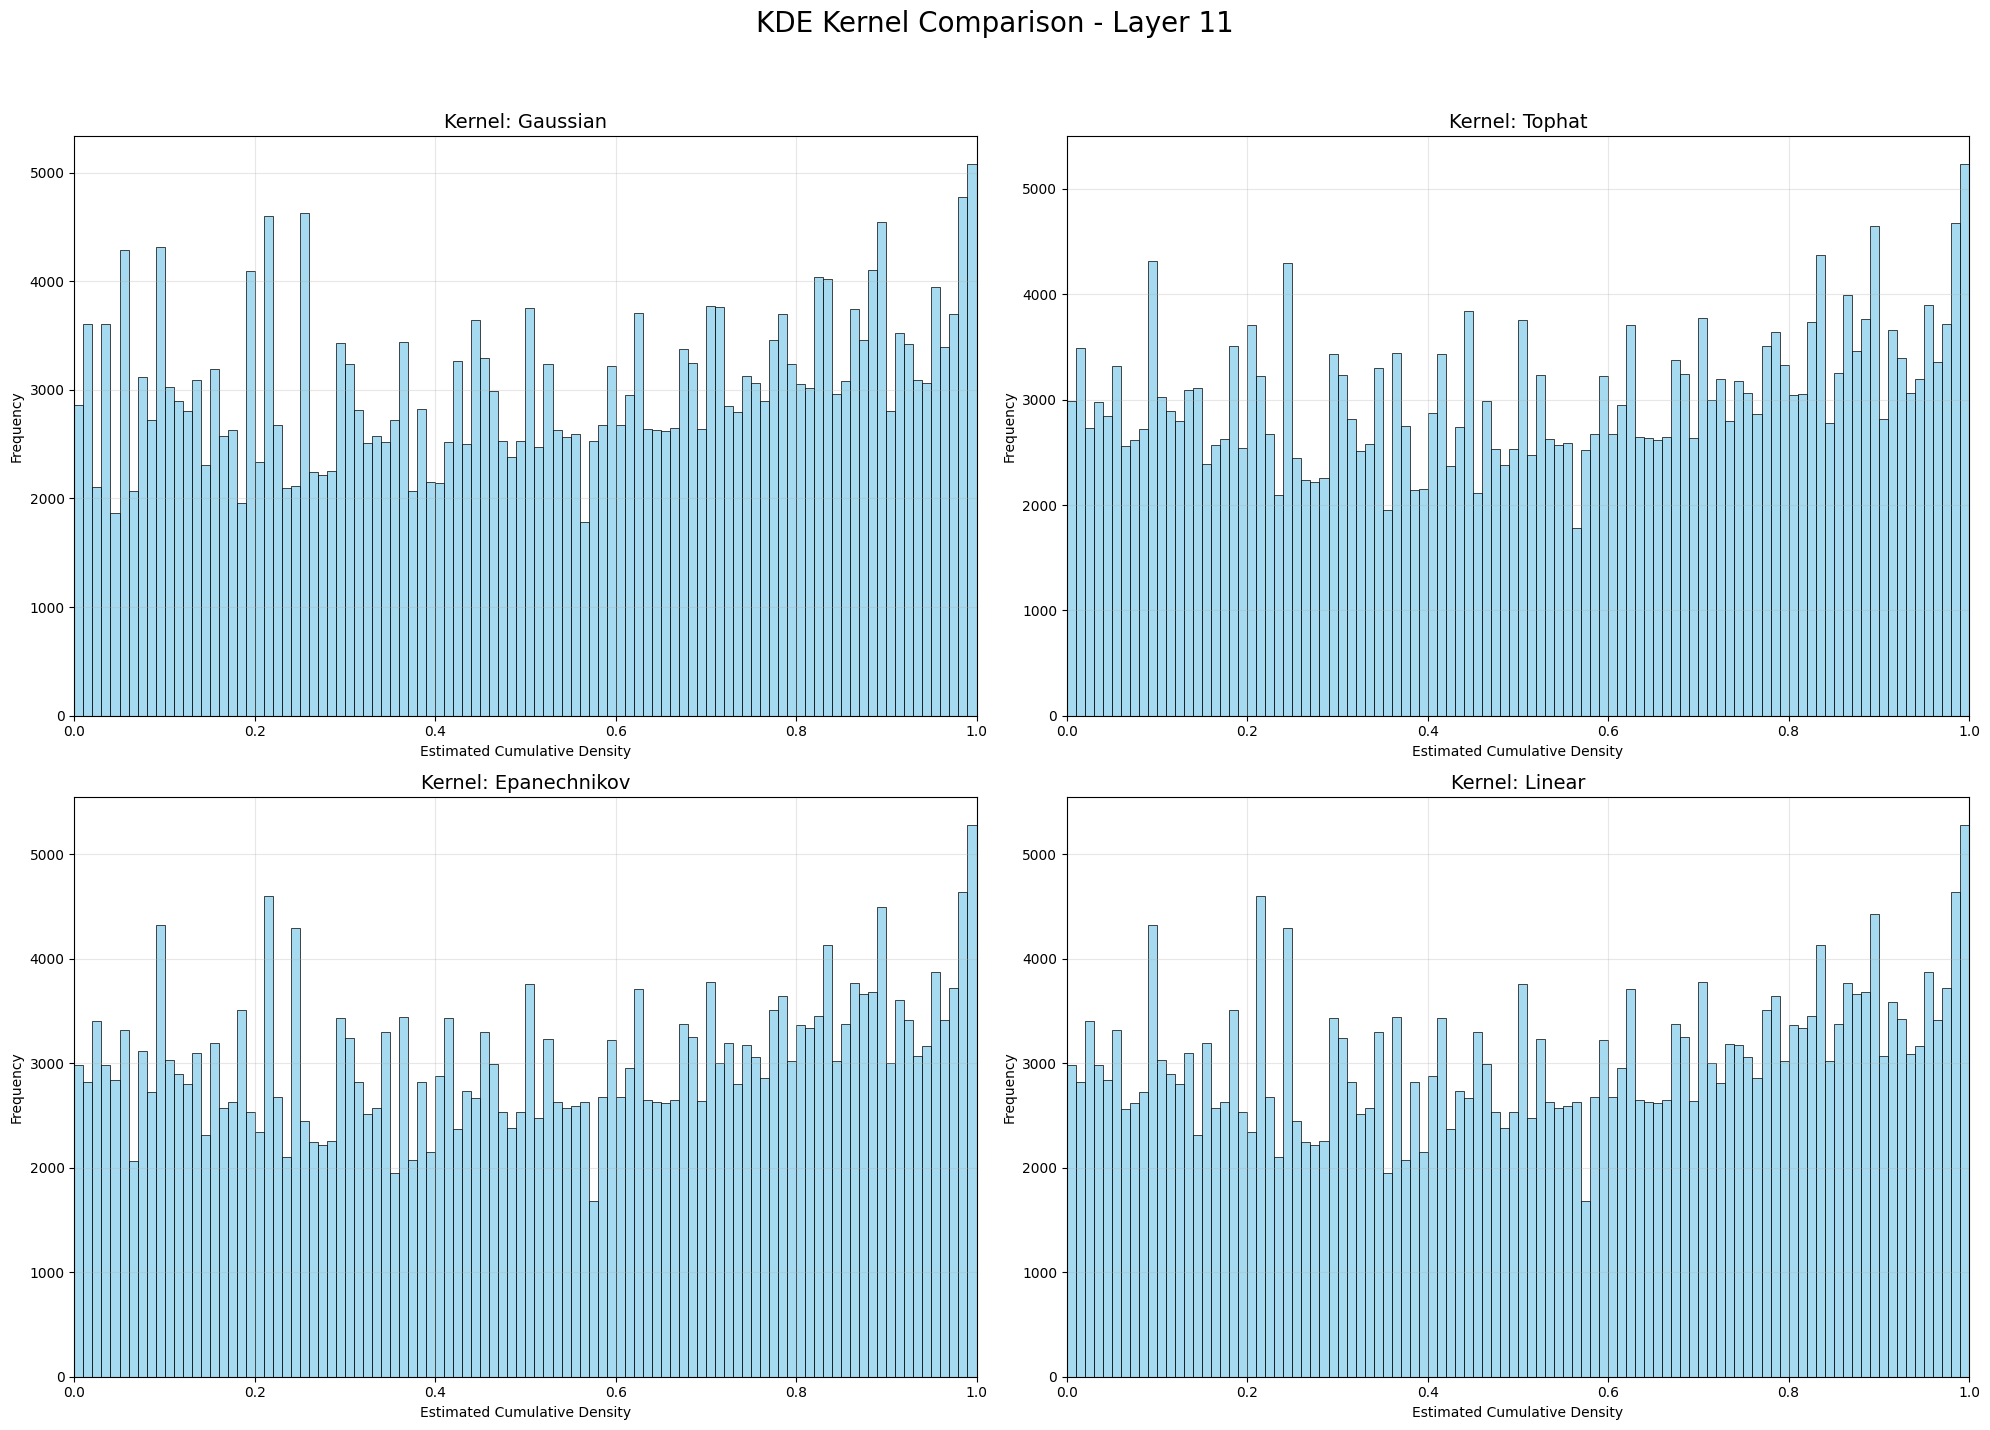

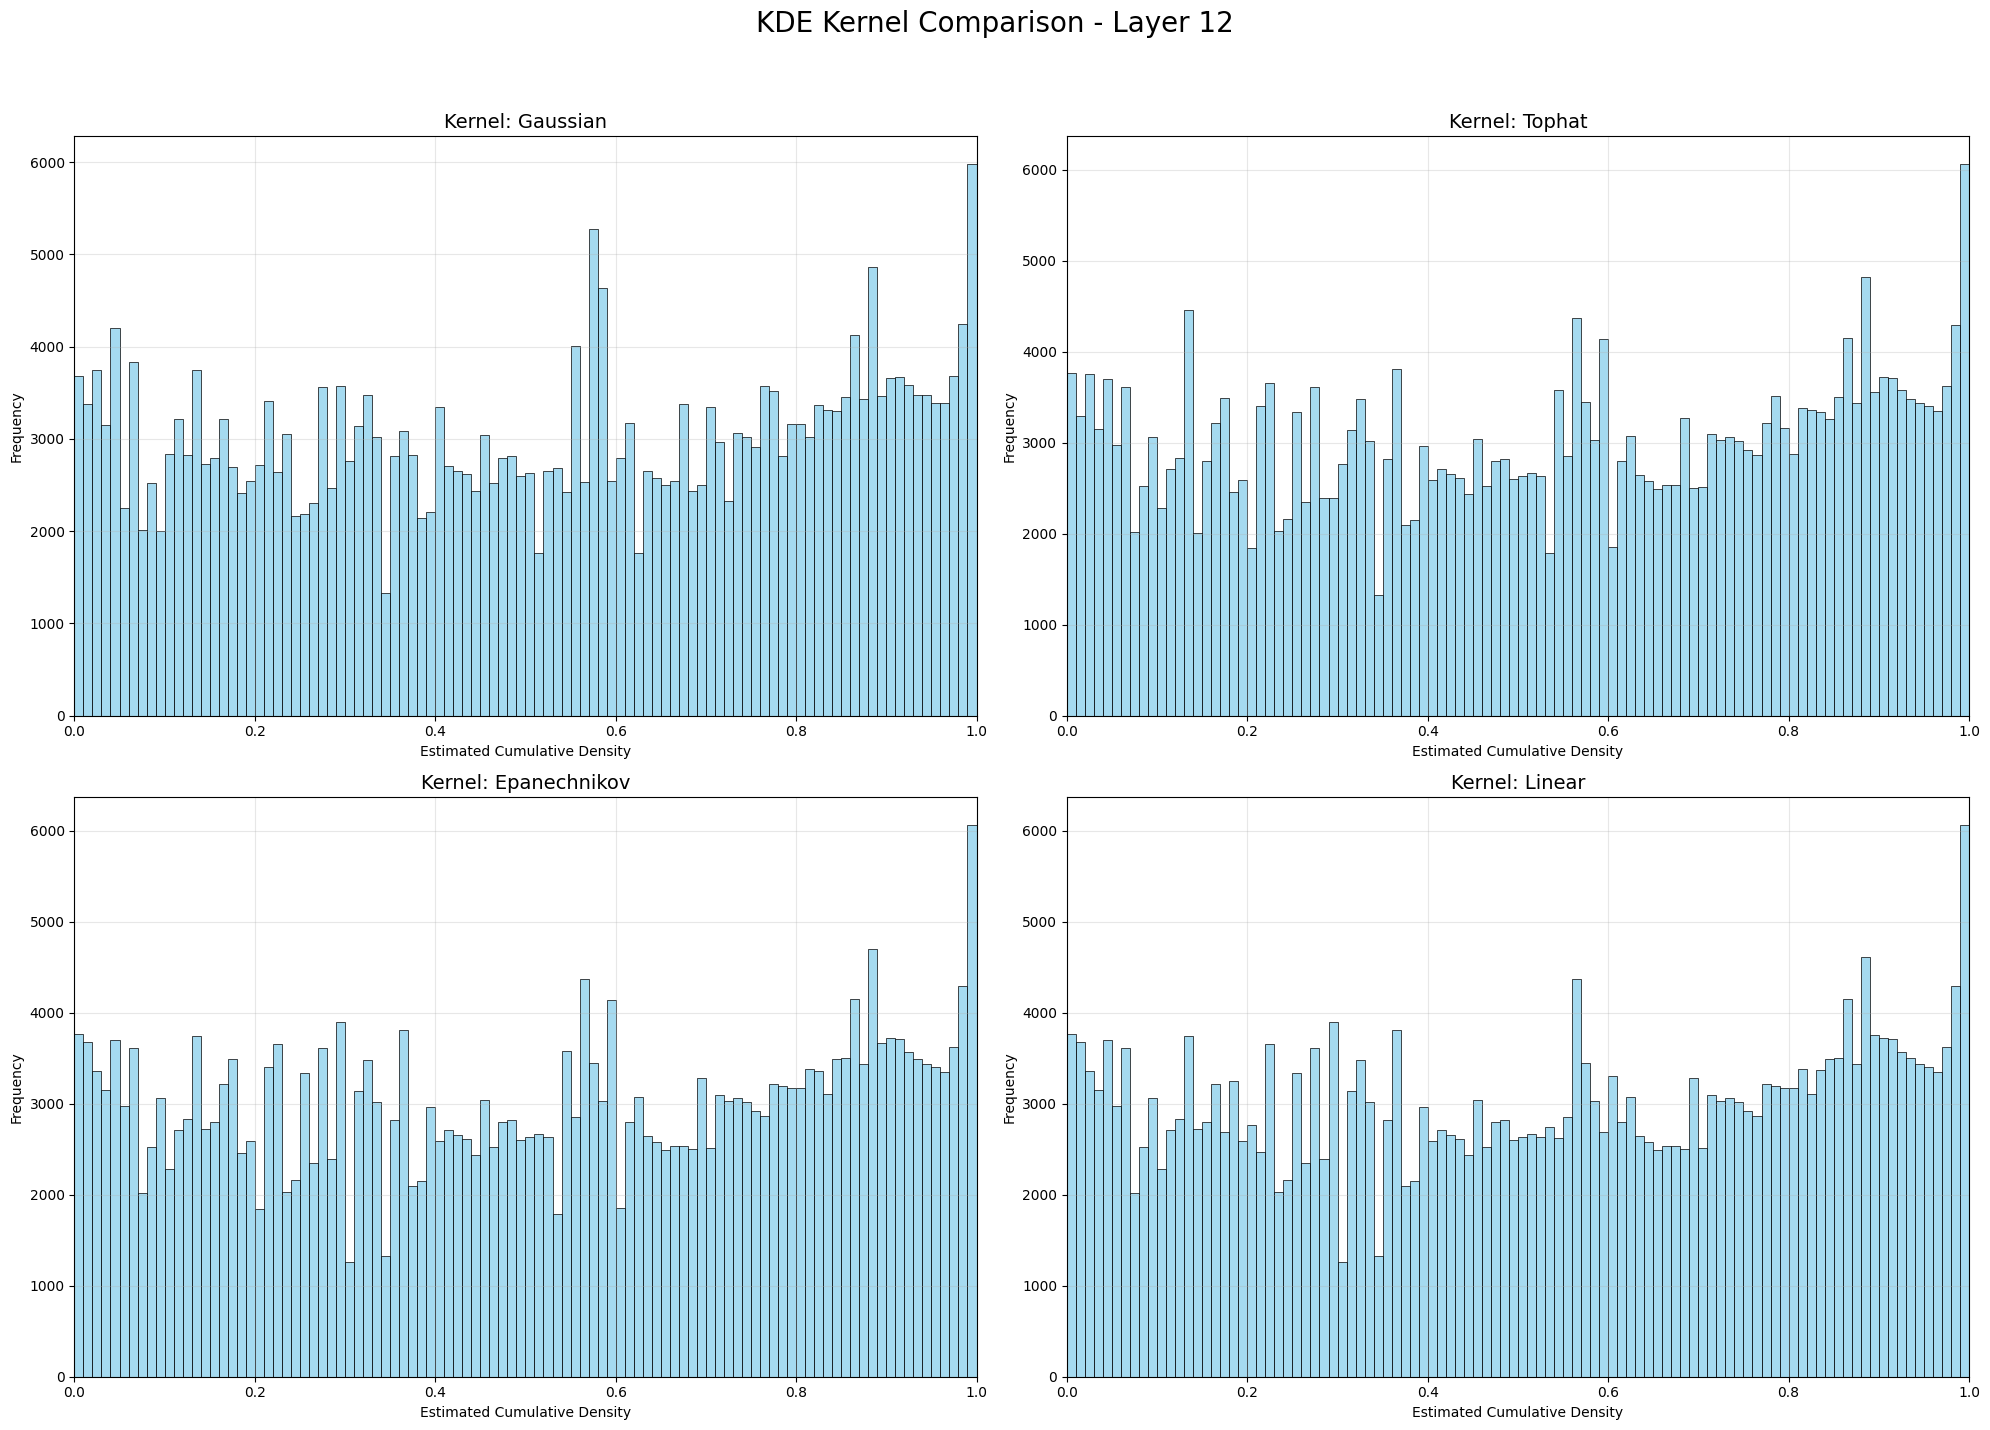

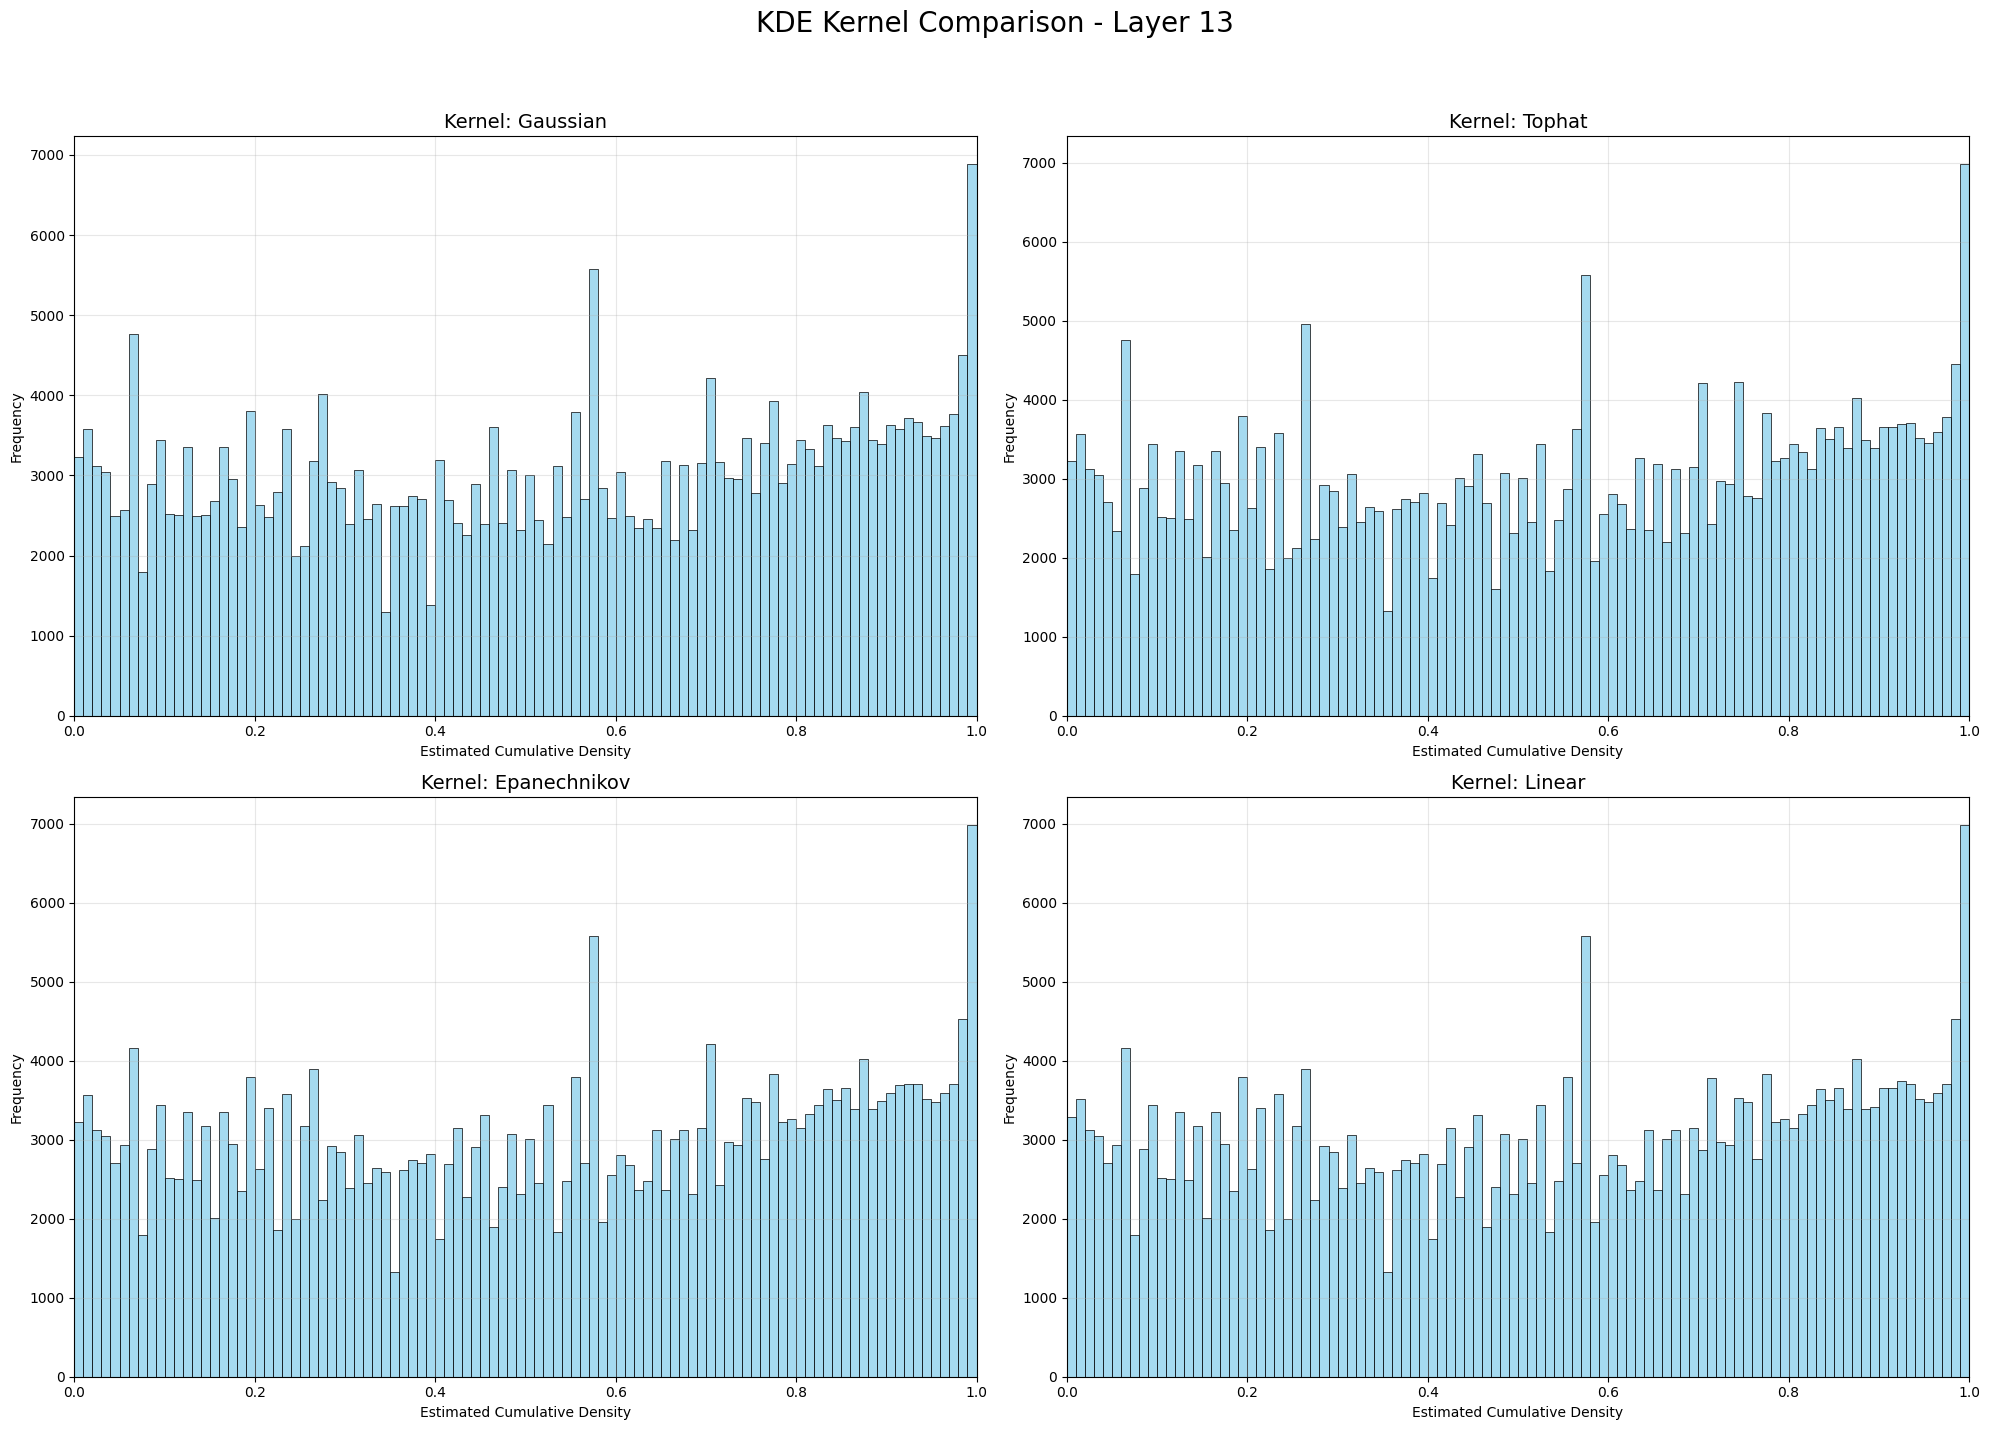

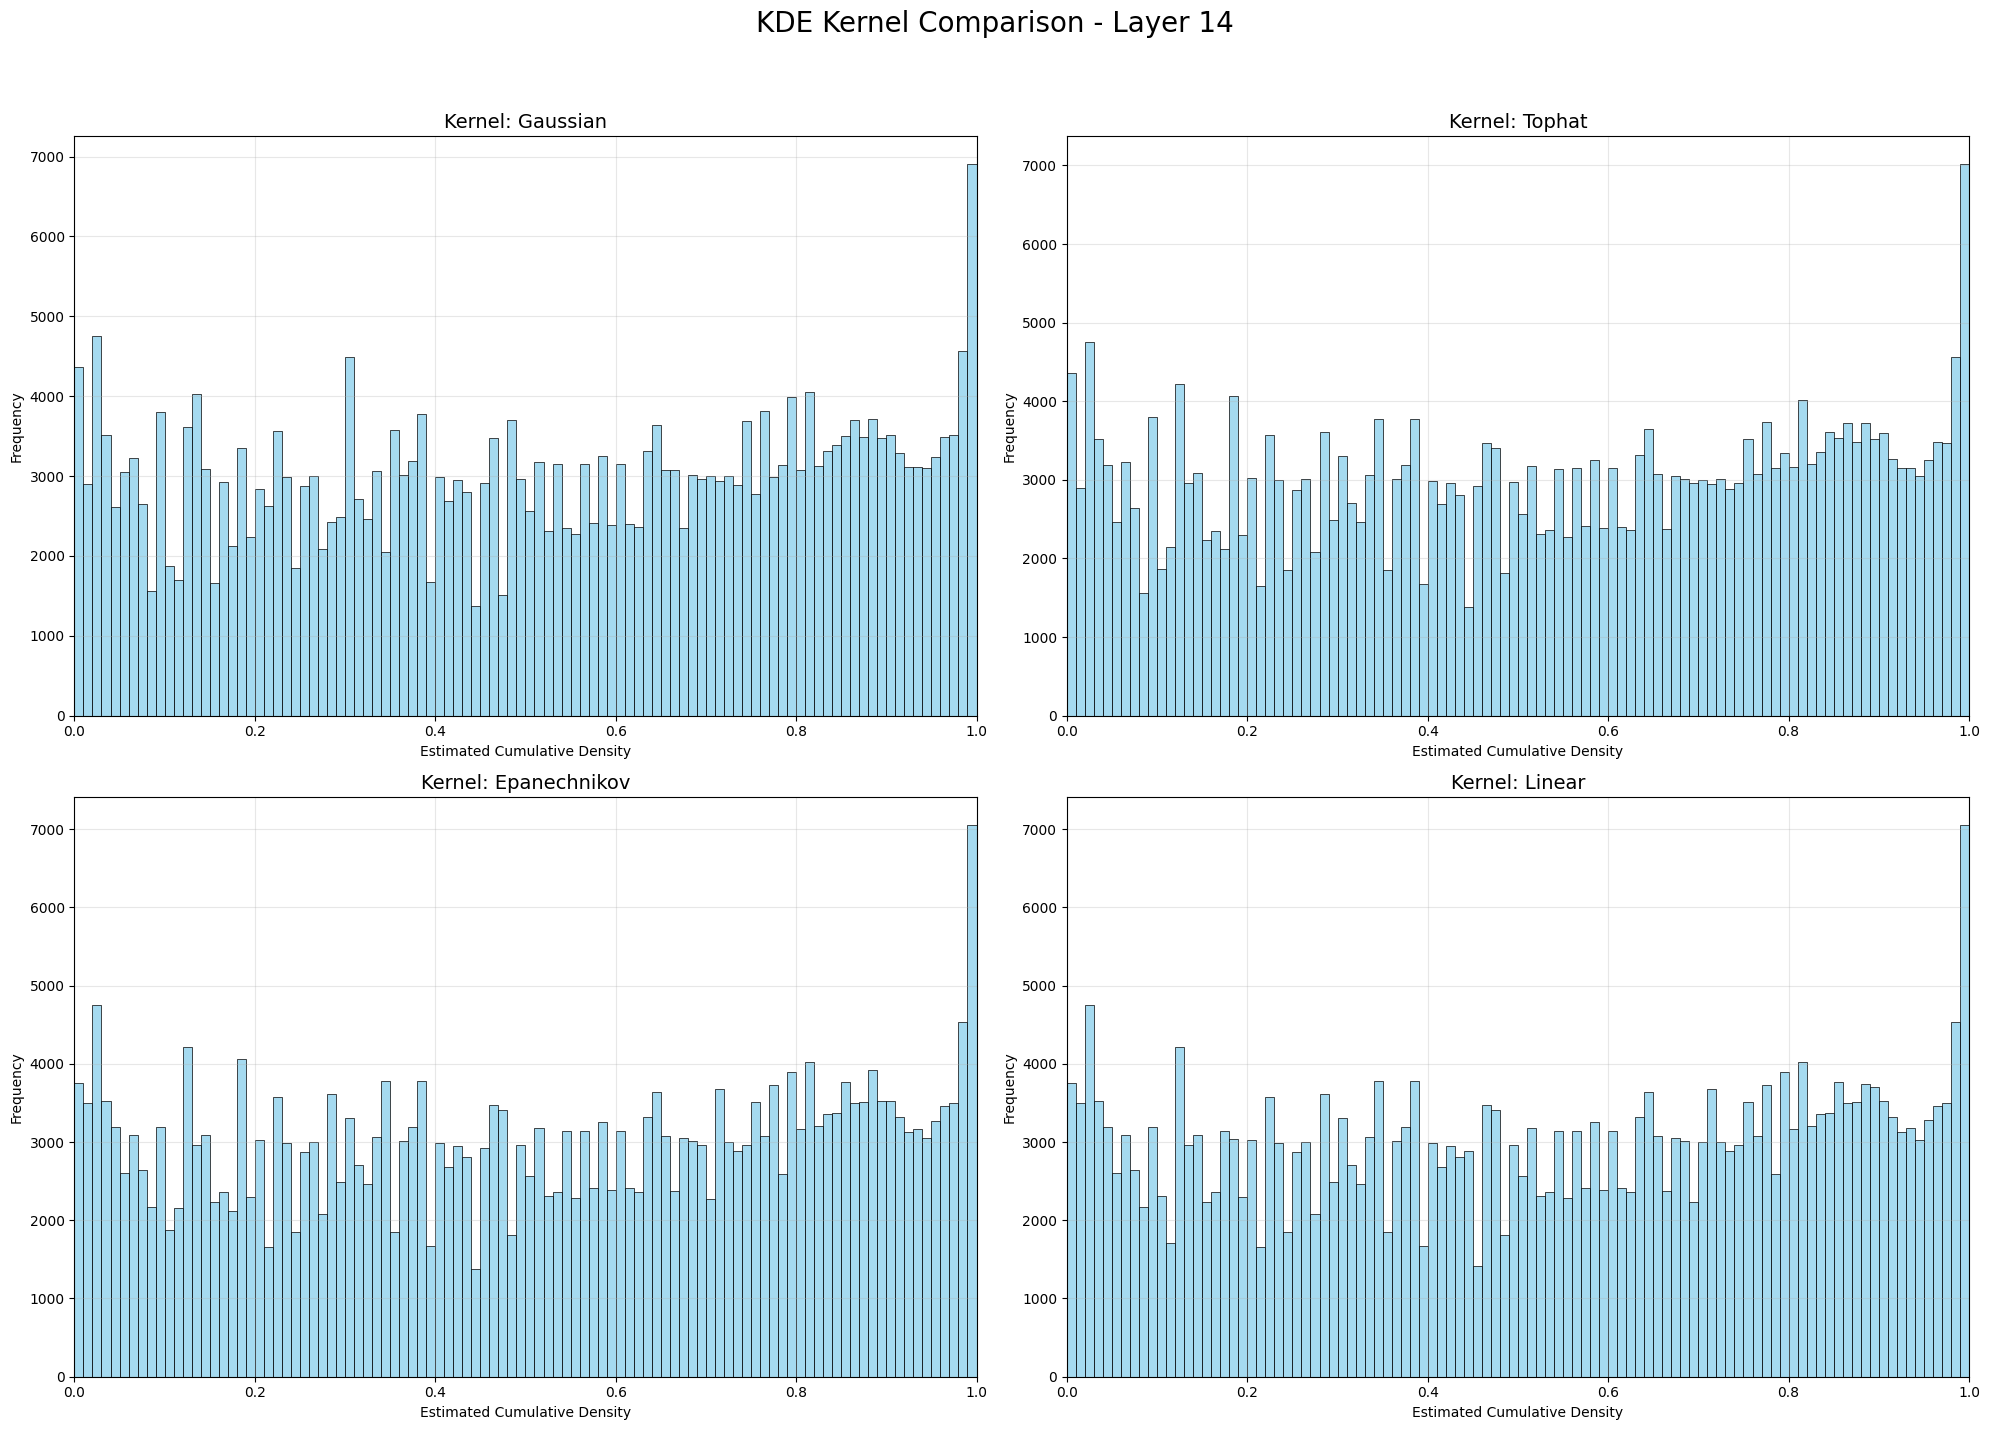

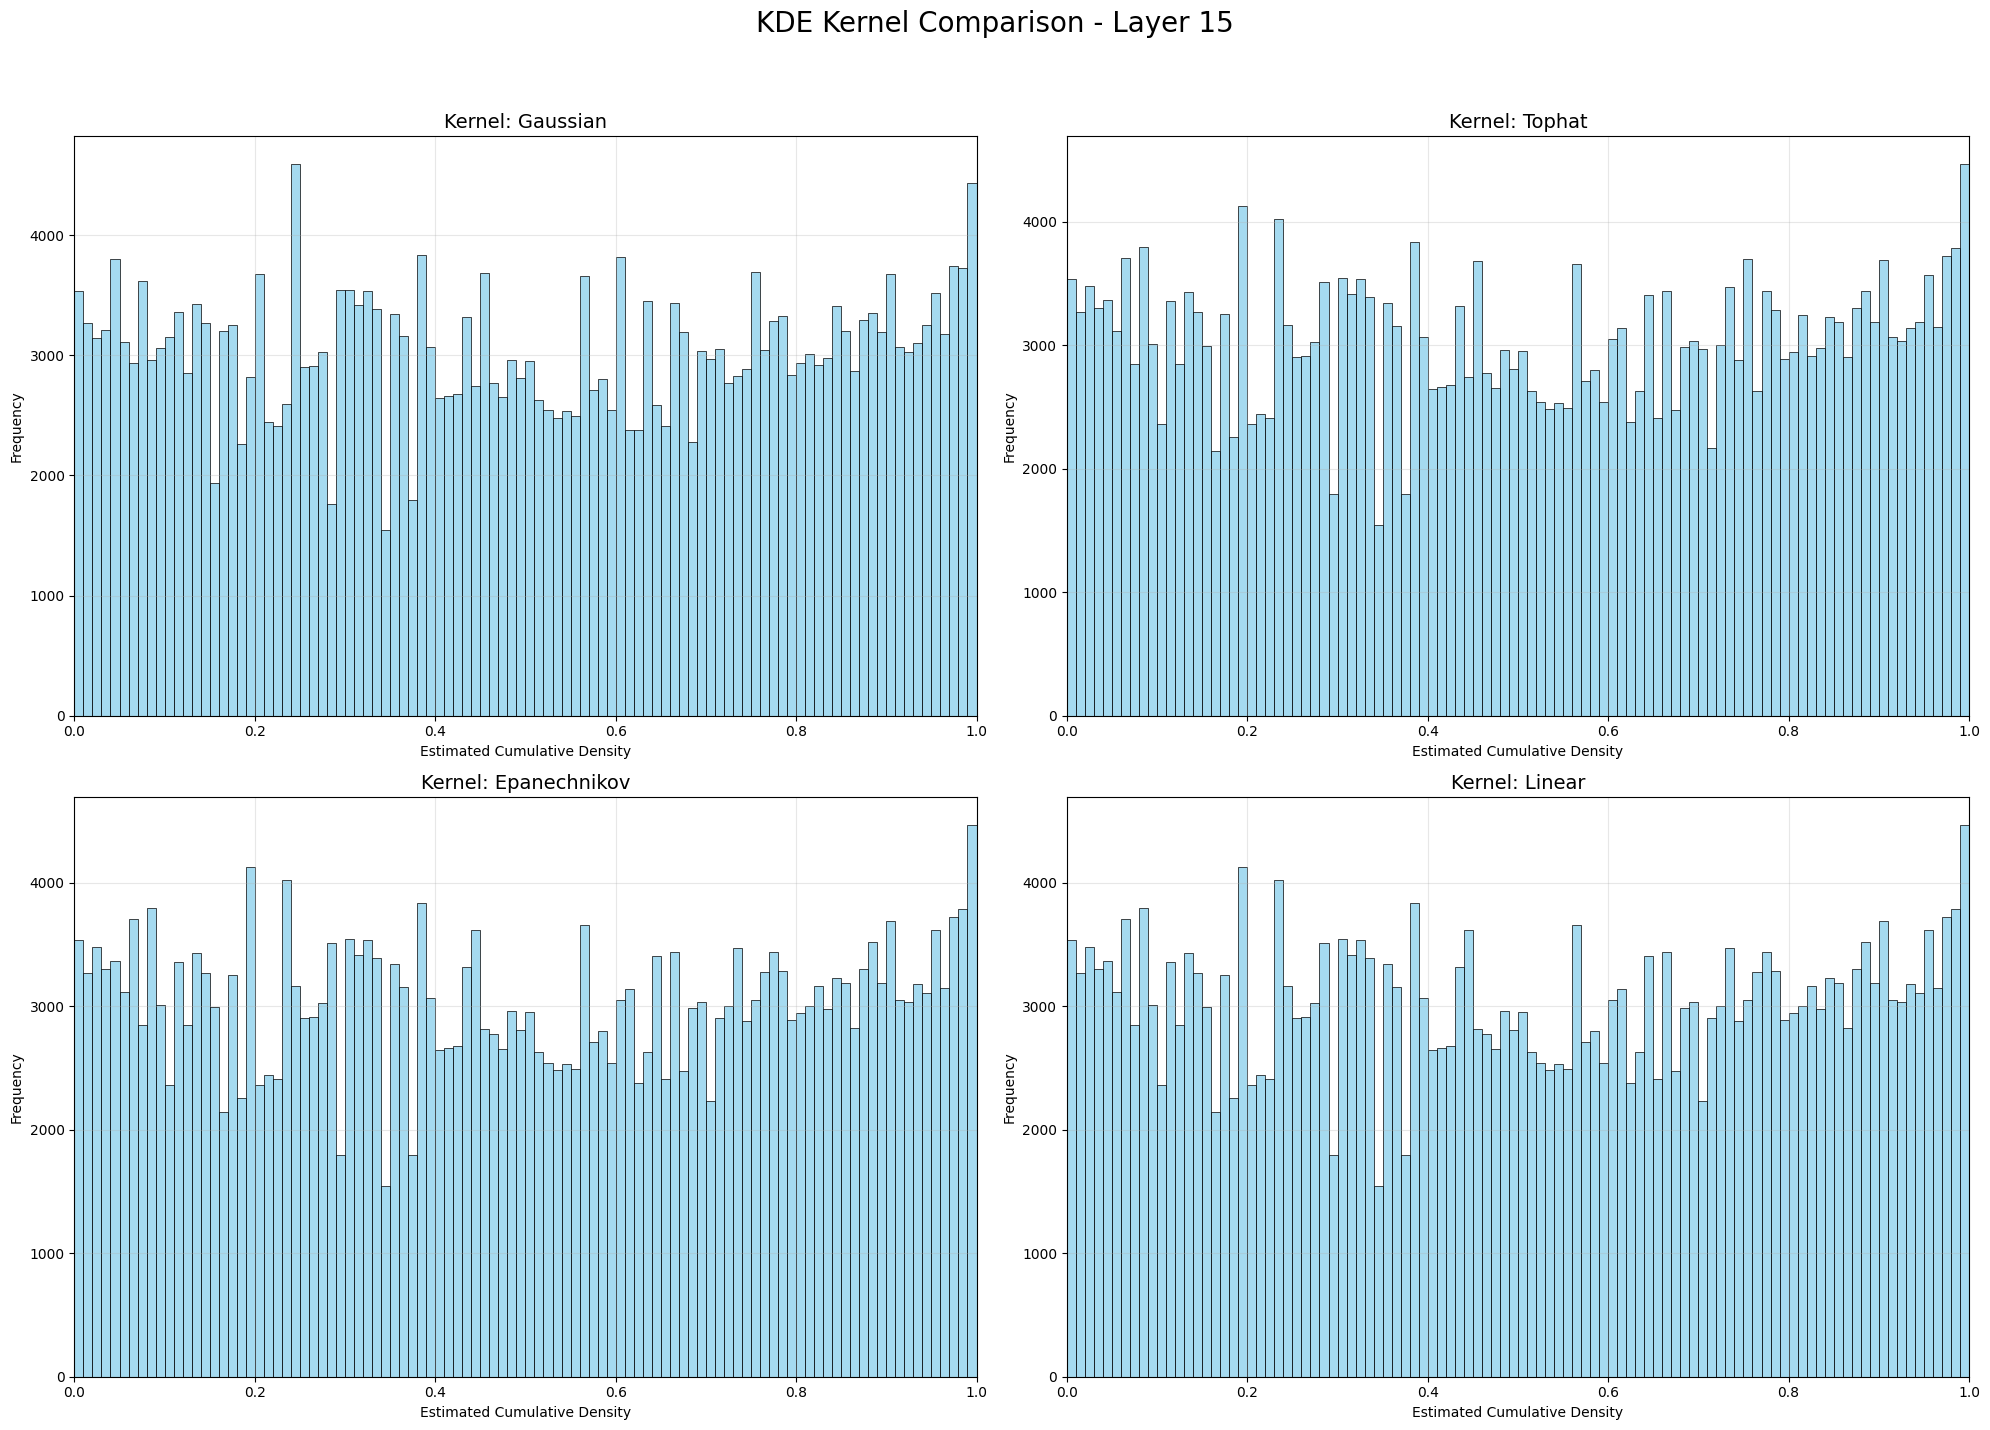

In [81]:
# Define exactly 4 kernels
KERNELS = ['gaussian', 'tophat', 'epanechnikov', 'linear']

for layer_idx in range(layers_router_logits_raw.shape[0]):
    path_to_dir = "./kde_models/models"
    os.makedirs(path_to_dir, exist_ok=True)
    
    layer_probabilities = {} 

    # --- Prepare Data ---
    train_data = layers_router_logits_raw[layer_idx].flatten()[:, np.newaxis]
    train_data_min, train_data_max = train_data.min(), train_data.max()
    
    x_grid = np.linspace(train_data_min - 0.2 * abs(train_data_min), 
                         train_data_max + 0.2 * abs(train_data_max), 10000)

    # --- 1. Train/Load Models ---
    for kernel_type in KERNELS:
        kde_model_filename = f"distribution_model_layer_{layer_idx}_{kernel_type}.pkl"
        model_path = os.path.join(path_to_dir, kde_model_filename)

        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                model_data = pickle.load(f)
                cdf_grid = model_data['cdf']
                loaded_x_grid = model_data['x']
        else:
            # Bandwidth Heuristic
            n = train_data.shape[0]
            std_dev = np.std(train_data)
            bandwidth = 1.06 * std_dev * (n ** (-1/5)) if std_dev > 0 else 1.0
            
            kde = KernelDensity(kernel=kernel_type, bandwidth=bandwidth)
            kde.fit(train_data)

            log_pdf = kde.score_samples(x_grid[:, np.newaxis])
            pdf_grid = np.exp(log_pdf)
            cdf_grid = np.cumsum(pdf_grid)
            cdf_grid /= cdf_grid[-1]

            with open(model_path, "wb") as f:
                pickle.dump({'x': x_grid, 'cdf': cdf_grid}, f)
            
            loaded_x_grid = x_grid

        # --- 2. Evaluate on Test Data ---
        test_layer_data = layers_router_logits_raw_wikitext[layer_idx].flatten()
        probs = np.interp(test_layer_data, loaded_x_grid, cdf_grid)
        layer_probabilities[kernel_type] = probs

    # --- 3. Plotting ---
    path_to_plot_dir = "./kde_models/plots"
    os.makedirs(path_to_plot_dir, exist_ok=True)
    path_to_save = os.path.join(path_to_plot_dir, f"kde_subplots_layer_{layer_idx}_wikitext.png")

    if os.path.exists(path_to_save):
        print(f"Plot for layer {layer_idx} already exists, skipping...")
        continue

    # Updated Plotting Logic
    plt.figure(figsize=(20, 15))
    
    for i, kernel_type in enumerate(KERNELS):
        # Activate the specific subplot (index starts at 1)
        plt.subplot(2, 2, i + 1)
        
        probs = layer_probabilities[kernel_type]
        
        # Plot on the active subplot
        sns.histplot(probs, bins=100, color='skyblue', edgecolor='black', linewidth=0.5)
        
        # Set attributes for the active subplot
        title_text = f"KDE Estimated P-Value with kernel: {kernel_type.capitalize()} - Layer {layer_idx} on Wikitext Data (overall {probs[idx].shape[0]} samples)"
        plt.title("\n".join(textwrap.wrap(title_text, width=70)))
        plt.xlabel("Estimated Cumulative Density")
        plt.ylabel("Frequency")
        plt.xlim(0, 1)
        plt.grid(alpha=0.3)

    plt.suptitle(f"KDE Kernel Comparison - Layer {layer_idx}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.savefig(path_to_save)
    plt.show()